# This code contains every ROUSEG and NETSEG experiment, including the computation of the features and feature selection. For it to run correctly, it requires a correct running of the "image_processing_and_tda" notebook with trial_flag=False. 

In [1]:
import numpy as np
import scipy
from scipy.stats import skew
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import os
import gudhi
from gudhi import CubicalComplex
from gudhi.wasserstein import wasserstein_distance
from gudhi.representations import Entropy
import imageio
import json
import functools
import sklearn
from sklearn import model_selection
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.model_selection import learning_curve, cross_val_score,RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from xgboost import XGBClassifier
import seaborn as sns
from antropy import perm_entropy

### Loading of lists

In [2]:
# Load ROUSEG lists 

with open("Lists/R_dist_ROUSEG.json", "r") as f:
    R_dist_ROUSEG=json.load(f)

with open("Lists/R_e0_ROUSEG.json", "r") as f:
    R_e0_ROUSEG=json.load(f)
    
with open("Lists/R_e1_ROUSEG.json", "r") as f:
    R_e1_ROUSEG=json.load(f)
    
with open("Lists/R_e2_ROUSEG.json", "r") as f:
    R_e2_ROUSEG=json.load(f)

with open("Lists/M_dist_ROUSEG.json", "r") as f:
    M_dist_ROUSEG=json.load(f)

with open("Lists/M_e0_ROUSEG.json", "r") as f:
    M_e0_ROUSEG=json.load(f)
    
with open("Lists/M_e1_ROUSEG.json", "r") as f:
    M_e1_ROUSEG=json.load(f)
    
with open("Lists/M_e2_ROUSEG.json", "r") as f:
    M_e2_ROUSEG=json.load(f)

with open("Lists/L_dist_ROUSEG.json", "r") as f:
    L_dist_ROUSEG=json.load(f)

with open("Lists/L_e0_ROUSEG.json", "r") as f:
    L_e0_ROUSEG=json.load(f)
    
with open("Lists/L_e1_ROUSEG.json", "r") as f:
    L_e1_ROUSEG=json.load(f)
    
with open("Lists/L_e2_ROUSEG.json", "r") as f:
    L_e2_ROUSEG=json.load(f)

In [3]:
# Load NETSEG lists 

with open("Lists/R_dist_NETSEG.json", "r") as f:
    R_dist_NETSEG=json.load(f)

with open("Lists/R_e0_NETSEG.json", "r") as f:
    R_e0_NETSEG=json.load(f)
    
with open("Lists/R_e1_NETSEG.json", "r") as f:
    R_e1_NETSEG=json.load(f)
    
with open("Lists/R_e2_NETSEG.json", "r") as f:
    R_e2_NETSEG=json.load(f)

with open("Lists/M_dist_NETSEG.json", "r") as f:
    M_dist_NETSEG=json.load(f)

with open("Lists/M_e0_NETSEG.json", "r") as f:
    M_e0_NETSEG=json.load(f)
    
with open("Lists/M_e1_NETSEG.json", "r") as f:
    M_e1_NETSEG=json.load(f)
    
with open("Lists/M_e2_NETSEG.json", "r") as f:
    M_e2_NETSEG=json.load(f)

with open("Lists/L_dist_NETSEG.json", "r") as f:
    L_dist_NETSEG=json.load(f)

with open("Lists/L_e0_NETSEG.json", "r") as f:
    L_e0_NETSEG=json.load(f)
    
with open("Lists/L_e1_NETSEG.json", "r") as f:
    L_e1_NETSEG=json.load(f)
    
with open("Lists/L_e2_NETSEG.json", "r") as f:
    L_e2_NETSEG=json.load(f)

In [4]:
ROUSEG_lists=[R_dist_ROUSEG,R_e0_ROUSEG,R_e1_ROUSEG,R_e2_ROUSEG,M_dist_ROUSEG,M_e0_ROUSEG,M_e1_ROUSEG,M_e2_ROUSEG,L_dist_ROUSEG,L_e0_ROUSEG,L_e1_ROUSEG,L_e2_ROUSEG]
NETSEG_lists=[R_dist_NETSEG,R_e0_NETSEG,R_e1_NETSEG,R_e2_NETSEG,M_dist_NETSEG,M_e0_NETSEG,M_e1_NETSEG,M_e2_NETSEG,L_dist_NETSEG,L_e0_NETSEG,L_e1_NETSEG,L_e2_NETSEG]

### Generate the dataframes

In [5]:
# Extract the groups (4 diseases and normal) and the training and test sets from the ACDC Dataset to avoid mistakes

groups_list=[]

base_path="ACDC/ACDC/database/"

for i in range(1,151):
    patient_path="patient"
    if (i <= 100):
        info_path=base_path+"training/"
        if (i < 100):
            patient_path=patient_path+"0"
            if (i < 10):
                patient_path=patient_path+"0"
    else:
        info_path=base_path+"testing/"

    filepath=info_path+patient_path+str(i)+"/"+"Info.cfg"
    
    with open(filepath, "r") as file:
        group = None
        for line in file:
            if line.startswith("Group:"):
                group = line.split(":")[1].strip()
                groups_list.append(group)

DCM_indices_train=[]
HCM_indices_train=[]
MINF_indices_train=[]
NOR_indices_train=[]
RV_indices_train=[]

DCM_indices_test=[]
HCM_indices_test=[]
MINF_indices_test=[]
NOR_indices_test=[]
RV_indices_test=[]

for i, group in enumerate (groups_list):
    if i<100:
        if (group=="DCM"):
            DCM_indices_train.append(i)
        if (group=="HCM"):
            HCM_indices_train.append(i)
        if (group=="MINF"):
            MINF_indices_train.append(i)
        if (group=="NOR"):
            NOR_indices_train.append(i)
        if (group=="RV"):
            RV_indices_train.append(i)
    else:
        if (group=="DCM"):
            DCM_indices_test.append(i)
        if (group=="HCM"):
            HCM_indices_test.append(i)
        if (group=="MINF"):
            MINF_indices_test.append(i)
        if (group=="NOR"):
            NOR_indices_test.append(i)
        if (group=="RV"):
            RV_indices_test.append(i)

indices_list_train=[DCM_indices_train,HCM_indices_train,MINF_indices_train,NOR_indices_train,RV_indices_train]
indices_list_test=[DCM_indices_test,HCM_indices_test,MINF_indices_test,NOR_indices_test,RV_indices_test]

In [6]:
#Functions to extract the metrics

def get_mean_list (listoflists):
    metric_list=[]
    for i in range(len (listoflists)):
        m=np.array(listoflists[i]).mean()
        metric_list.append(m)
    return metric_list

def get_var_list (listoflists):
    metric_list=[]
    for i in range(len (listoflists)):
        m=np.array(listoflists[i]).var()
        metric_list.append(m)
    return metric_list

def get_skew_list (listoflists):
    metric_list=[]
    for i in range(len (listoflists)):
        m=skew(listoflists[i])
        metric_list.append(m)
    return metric_list

def get_jumps_list (listoflists):
    metric_list=[]
    for i in range(len (listoflists)):
        m=np.sum(np.abs(np.diff(np.array(listoflists[i]))))
        #NORMALIZED
        m=m/len(listoflists[i])
        metric_list.append(m)
    return metric_list

def get_permentro_list (listoflists):
    metric_list=[]
    for i in range(len (listoflists)):
        m=perm_entropy(np.array(listoflists[i]), order=3, delay=1, normalize=True)
        metric_list.append(m)
    return metric_list

def get_argmax_list (listoflists):
    metric_list=[]
    for i in range(len (listoflists)):
        m=np.argmax(np.array(listoflists[i]))
        #NORMALIZED
        m=m/len(listoflists[i])
        metric_list.append(m)
    return metric_list

def get_argmin_list (listoflists):
    metric_list=[]
    for i in range(len (listoflists)):
        m=np.argmin(np.array(listoflists[i]))
        #NORMALIZED
        m=m/len(listoflists[i])
        metric_list.append(m)
    return metric_list

#General function to get every metric from the ROUSEG_lists and NETSEG_lists
def get_metrics(listcubed):

    listcubed_mean=[]
    listcubed_var=[]
    listcubed_skew=[]
    listcubed_jumps=[]
    listcubed_permentro=[]
    listcubed_argmax=[]
    listcubed_argmin=[]

    listcubed_metrics=[]
    
    for listoflists in listcubed:
        listcubed_mean.append(get_mean_list(listoflists))
        listcubed_var.append(get_var_list(listoflists))
        listcubed_skew.append(get_skew_list(listoflists))
        listcubed_jumps.append(get_jumps_list(listoflists))
        listcubed_permentro.append(get_permentro_list(listoflists))
        listcubed_argmax.append(get_argmax_list(listoflists))
        listcubed_argmin.append(get_argmin_list(listoflists))
    
    listcubed_metrics=[listcubed_mean,listcubed_var,listcubed_skew,listcubed_jumps,listcubed_permentro,listcubed_argmax,listcubed_argmin]
    return listcubed_metrics

In [7]:
ROUSEG_metrics=get_metrics(ROUSEG_lists)
NETSEG_metrics=get_metrics(NETSEG_lists)

In [8]:
# Function to divide the lists according to the groups indices
def get_list_by_group(listt,indices):
    new_list=[]
    for i in indices:
        new_list.append(listt[i])

    return new_list

# The function to generate a list ordered according to the variables, metrics and groups
def generate_working_list(listcubed_metrics, indices_list, nvariables=12, nmetrics=7):
    working_list=[]
    
    for variable in range(0,nvariables):
        for metric in range (0,nmetrics):
            aux=listcubed_metrics[metric][variable]
            for index_list in indices_list:
                new_list=get_list_by_group(aux,index_list)
                working_list.append(new_list)

    return working_list

In [9]:
ROUSEG_train_list=generate_working_list(ROUSEG_metrics, indices_list_train)
ROUSEG_test_list=generate_working_list(ROUSEG_metrics, indices_list_test)
NETSEG_train_list=generate_working_list(NETSEG_metrics, indices_list_train)
NETSEG_test_list=generate_working_list(NETSEG_metrics, indices_list_test)

These train / test lists have 420 lists of 20 or 10 lists, ordered with the hierarchy variable->metric->group (12x7x5=420) according to the orders:

[R_dist,R_e0,R_e1,R_e2,M_dist,M_e0,M_e1,M_e2,L_dist,L_e0,L_e1,L_e2] 

[mean,var,skew,jumps,permentro,argmax,argmin]

[DCM, HCM, MINF, NOR, RV]

This means:

List 0 is R_dist_mean_DCM

List 1 is R_dist_mean_HCM

List 2 is R_dist_mean_MINF

List 3 is R_dist_mean_NOR

List 4 is R_dist_mean_RV

List 5 is R_dist_var_DCM

...

List 35 is R_e0_mean_DCM

List 36 is R_e0_mean_HCM

...

List 419 is L_e2_argmin_RV

In [10]:
features_list = [
    "R_dist_mean", "R_dist_var", "R_dist_skew", "R_dist_jumps", "R_dist_permentro", 
    "R_dist_argmax", "R_dist_argmin", "R_e0_mean", "R_e0_var", "R_e0_skew", 
    "R_e0_jumps", "R_e0_permentro", "R_e0_argmax", "R_e0_argmin", 
    "R_e1_mean", "R_e1_var", "R_e1_skew", "R_e1_jumps", "R_e1_permentro", 
    "R_e1_argmax", "R_e1_argmin", "R_e2_mean", "R_e2_var", "R_e2_skew",
    "R_e2_jumps", "R_e2_permentro", "R_e2_argmax", "R_e2_argmin", 
    "M_dist_mean", "M_dist_var", "M_dist_skew", "M_dist_jumps", "M_dist_permentro", 
    "M_dist_argmax", "M_dist_argmin", "M_e0_mean", "M_e0_var", "M_e0_skew", 
    "M_e0_jumps", "M_e0_permentro", "M_e0_argmax", "M_e0_argmin", 
    "M_e1_mean", "M_e1_var", "M_e1_skew", "M_e1_jumps", "M_e1_permentro", 
    "M_e1_argmax", "M_e1_argmin", "M_e2_mean", "M_e2_var", "M_e2_skew",
    "M_e2_jumps", "M_e2_permentro", "M_e2_argmax", "M_e2_argmin", 
    "L_dist_mean", "L_dist_var", "L_dist_skew", "L_dist_jumps", "L_dist_permentro", 
    "L_dist_argmax", "L_dist_argmin", "L_e0_mean", "L_e0_var", "L_e0_skew",
    "L_e0_jumps", "L_e0_permentro", "L_e0_argmax", "L_e0_argmin", 
    "L_e1_mean", "L_e1_var", "L_e1_skew", "L_e1_jumps", "L_e1_permentro", 
    "L_e1_argmax", "L_e1_argmin", "L_e2_mean", "L_e2_var", "L_e2_skew", 
    "L_e2_jumps", "L_e2_permentro", "L_e2_argmax", "L_e2_argmin"
]

In [11]:
def build_df(working_list,features_list):

        data=[]
    
        for i in range(len(features_list)):
            aux=working_list[5*i]+working_list[5*i+1]+working_list[5*i+2]+working_list[5*i+3]+working_list[5*i+4]
            data.append(aux)
        
        df = pd.DataFrame(data).T

        # The only metric susceptible to generate nans is skewness, so it makes sense to fill with zeros
        df=df.fillna(0)
        
        df.columns = features_list
        
        return df

In [12]:
ROUSEG_train=build_df(ROUSEG_train_list,features_list)
ROUSEG_test=build_df(ROUSEG_test_list,features_list)
NETSEG_train=build_df(NETSEG_train_list,features_list)
NETSEG_test=build_df(NETSEG_test_list,features_list)

In [13]:
# Generate the label vectors and encode them

y_str_tr=[""]*100
y_str_te=[""]*50

y_str_tr[0:20]=["DCM"]*20
y_str_tr[20:40]=["HCM"]*20
y_str_tr[40:60]=["MINF"]*20
y_str_tr[60:80]=["NOR"]*20
y_str_tr[80:100]=["RV"]*20

y_str_te[0:10]=["DCM"]*10
y_str_te[10:20]=["HCM"]*10
y_str_te[20:30]=["MINF"]*10
y_str_te[30:40]=["NOR"]*10
y_str_te[40:50]=["RV"]*10

le = LabelEncoder()
y_train = le.fit_transform(y_str_tr)
y_test = le.fit_transform(y_str_te)

### Feature selection

In [14]:
#This is necessary to ensure replicability of the experiments.
mutual_info_classif_fixed = functools.partial(mutual_info_classif, random_state=42)

In [15]:
#The Mutual Information function, that orders features according to their MI Scores, plots it and outputs a list as well
def Mutual_Information(X_train,y_train, features_list):

    mi_scores = mutual_info_classif_fixed(X_train, y_train)
    
    sorted_indices = np.argsort(mi_scores)[::-1]
    sorted_mi_scores = mi_scores[sorted_indices]
    sorted_features = np.array(features_list)[sorted_indices]
    
    mi_table = pd.DataFrame({
        "Feature": sorted_features,
        "Mutual Information Score": sorted_mi_scores
    })

    print(mi_table.to_markdown(index=False))
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(sorted_mi_scores) + 1), sorted_mi_scores, marker='o', linestyle='-')
    plt.title("Entropy Mutual Information Scores")
    plt.xlabel("Features (Ranked)")
    plt.ylabel("Mutual Information Score")
    plt.grid(True)
    plt.show()

| Feature          |   Mutual Information Score |
|:-----------------|---------------------------:|
| L_e0_mean        |                 0.588736   |
| L_e1_mean        |                 0.470237   |
| L_e2_mean        |                 0.468011   |
| R_e2_mean        |                 0.408692   |
| R_e0_mean        |                 0.399721   |
| L_e0_var         |                 0.386066   |
| R_e0_var         |                 0.385742   |
| L_e1_jumps       |                 0.357864   |
| R_e1_mean        |                 0.336981   |
| L_e1_var         |                 0.313763   |
| L_e2_var         |                 0.308686   |
| M_e1_jumps       |                 0.295472   |
| M_e0_mean        |                 0.272543   |
| L_e0_jumps       |                 0.244934   |
| R_e1_var         |                 0.237003   |
| M_dist_var       |                 0.234757   |
| M_dist_jumps     |                 0.231593   |
| L_e1_argmin      |                 0.22872    |


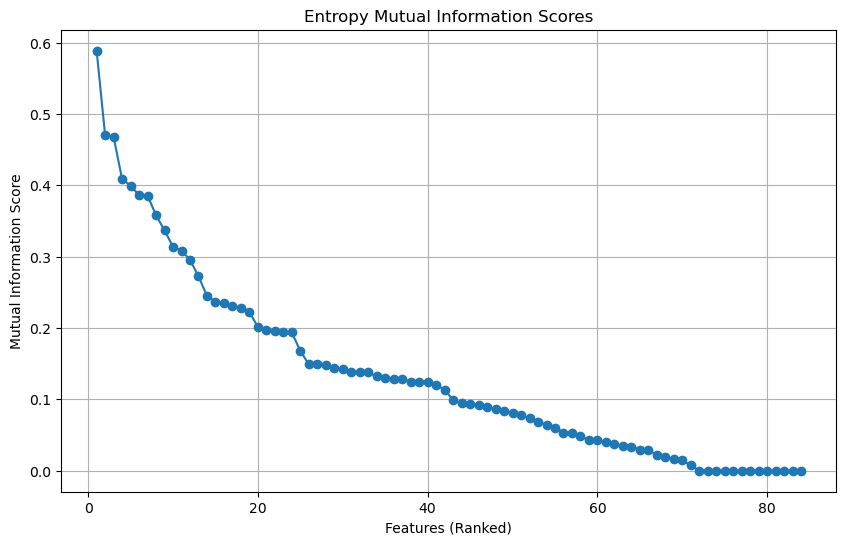

In [16]:
Mutual_Information(ROUSEG_train,y_train,features_list)

| Feature          |   Mutual Information Score |
|:-----------------|---------------------------:|
| L_e2_var         |                  0.581166  |
| L_e2_jumps       |                  0.527956  |
| L_e1_var         |                  0.524543  |
| L_e0_jumps       |                  0.425281  |
| R_e0_jumps       |                  0.371193  |
| L_e1_jumps       |                  0.358846  |
| R_e1_mean        |                  0.350789  |
| L_e2_mean        |                  0.333611  |
| R_e0_mean        |                  0.332286  |
| L_e0_var         |                  0.328601  |
| L_e0_mean        |                  0.312192  |
| M_e2_mean        |                  0.310331  |
| L_e1_mean        |                  0.297011  |
| R_e1_jumps       |                  0.267534  |
| M_e2_var         |                  0.259066  |
| M_e1_var         |                  0.251419  |
| L_e1_argmin      |                  0.228363  |
| R_e2_mean        |                  0.217956  |


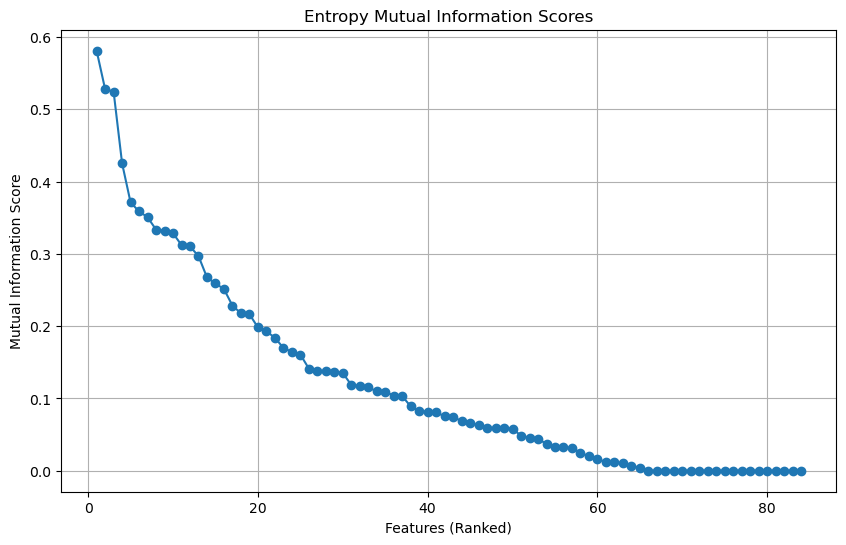

In [17]:
Mutual_Information(NETSEG_train,y_train,features_list)

### Start classification

In [18]:
# Some functions for visualization of classification

def conf_matrix(y_test,y_pred,title,color):
    categories = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']
    cm = confusion_matrix(y_test, y_pred, labels=range(len(categories)))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap=color, xticks_rotation=45)
    plt.title(title)
    plt.show()

def plot_multiclass_roc(y_test, y_probs, classes, model_name):
    n_classes = len(classes)
    fpr = {}
    tpr = {}
    roc_auc = {}

    class_colors = ['red', 'blue', 'green', 'orange', 'purple']

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_roc_auc = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})', color=class_colors[i])
    plt.plot(all_fpr, mean_tpr, color='black', lw=2, linestyle='--', label=f'Macro-average (AUC = {macro_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [19]:
# Classification functions. This contains:
#1. Feature selection with Mutual Information, with the amount of features to take as a variable
#2. 5-fold cross validation for GridSearch hyperparameter tuning.
#3. Five models: SVM, KNN, Random Forest, Gradient Boosting and XGB.

def Classification_5Models(X_train, X_test, y_train, y_test, k=len(features_list), n_splits=5):
    
    # Feature selection
    selector = SelectKBest(score_func=mutual_info_classif_fixed, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    selected_indices = selector.get_support(indices=True)
    X_test_selected = selector.transform(X_test)

    # SVM and KNN need scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Binarize for the ROC-AUC curve
    class_names = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']
    y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

    # 5-fold CV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # SVM
    svm_params = {
        "C": [0.1, 1, 10, 100],
        "gamma": [0.0001, 0.001, 0.01, 0.1, 1],
        "kernel": ["linear", "rbf", "sigmoid", "poly"],
        "degree": [2,3,4]
    }
    svm_model = GridSearchCV(SVC(probability=True, random_state=42),
                             param_grid=svm_params,
                             cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    svm_model.fit(X_train_scaled, y_train)
    print("\nBest parameters for SVM:", svm_model.best_params_)
    y_pred_svm = svm_model.predict(X_test_scaled)
    y_probs_svm = svm_model.predict_proba(X_test_scaled)

    print("\nClassification Report (SVM):")
    print(classification_report(y_test, y_pred_svm, target_names=class_names))
    print(f"Macro ROC-AUC (SVM): {roc_auc_score(y_test_bin, y_probs_svm, average='macro'):.2f}")
    conf_matrix(y_test, y_pred_svm, "SVM", plt.cm.Blues)
    plot_multiclass_roc(y_test_bin, y_probs_svm, class_names, "SVM")

    # KNN
    knn_params = {
        "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
        "weights": ["uniform", "distance"],
        "p": [1, 2]
    }
    knn_model = GridSearchCV(KNeighborsClassifier(),
                             param_grid=knn_params,
                             cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    knn_model.fit(X_train_scaled, y_train)
    print("\nBest parameters for KNN:", knn_model.best_params_)
    y_pred_knn = knn_model.predict(X_test_scaled)
    y_probs_knn = knn_model.predict_proba(X_test_scaled)

    print("\nClassification Report (KNN):")
    print(classification_report(y_test, y_pred_knn, target_names=class_names))
    print(f"Macro ROC-AUC (KNN): {roc_auc_score(y_test_bin, y_probs_knn, average='macro'):.2f}")
    conf_matrix(y_test, y_pred_knn, "KNN", plt.cm.Oranges)
    plot_multiclass_roc(y_test_bin, y_probs_knn, class_names, "KNN")

    # Random Forest
    rf_params = {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    }
    rf_model = GridSearchCV(RandomForestClassifier(random_state=42),
                            param_grid=rf_params,
                            cv=skf,
                            scoring='accuracy',
                            n_jobs=-1)
    rf_model.fit(X_train_selected, y_train)
    print("\nBest parameters for Random Forest:", rf_model.best_params_)
    y_pred_rf = rf_model.predict(X_test_selected)
    y_probs_rf = rf_model.predict_proba(X_test_selected)

    print("\nClassification Report (Random Forest):")
    print(classification_report(y_test, y_pred_rf, target_names=class_names))
    print(f"Macro ROC-AUC (Random Forest): {roc_auc_score(y_test_bin, y_probs_rf, average='macro'):.2f}")
    conf_matrix(y_test, y_pred_rf, "Random Forest", plt.cm.Greens)
    plot_multiclass_roc(y_test_bin, y_probs_rf, class_names, "Random Forest")

    # Gradient Boosting
    gb_params = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    }
    gb_model = GridSearchCV(GradientBoostingClassifier(random_state=42),
                            param_grid=gb_params,
                            cv=skf,
                            scoring='accuracy',
                            n_jobs=-1)
    gb_model.fit(X_train_selected, y_train)
    print("\nBest parameters for Gradient Boosting:", gb_model.best_params_)
    y_pred_gb = gb_model.predict(X_test_selected)
    y_probs_gb = gb_model.predict_proba(X_test_selected)

    print("\nClassification Report (Gradient Boosting):")
    print(classification_report(y_test, y_pred_gb, target_names=class_names))
    print(f"Macro ROC-AUC (Gradient Boosting): {roc_auc_score(y_test_bin, y_probs_gb, average='macro'):.2f}")
    conf_matrix(y_test, y_pred_gb, "Gradient Boosting", plt.cm.Purples)
    plot_multiclass_roc(y_test_bin, y_probs_gb, class_names, "Gradient Boosting")

    # XGBoost
    xgb_params = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    }
    xgb_model = GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'),
                             param_grid=xgb_params,
                             cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    xgb_model.fit(X_train_selected, y_train)
    print("\nBest parameters for XGBoost:", xgb_model.best_params_)
    y_pred_xgb = xgb_model.predict(X_test_selected)
    y_probs_xgb = xgb_model.predict_proba(X_test_selected)

    print("\nClassification Report (XGBoost):")
    print(classification_report(y_test, y_pred_xgb, target_names=class_names))
    print(f"Macro ROC-AUC (XGBoost): {roc_auc_score(y_test_bin, y_probs_xgb, average='macro'):.2f}")
    conf_matrix(y_test, y_pred_xgb, "XGBoost", plt.cm.Reds)
    plot_multiclass_roc(y_test_bin, y_probs_xgb, class_names, "XGBoost")


Best parameters for SVM: {'C': 10, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}

Classification Report (SVM):
              precision    recall  f1-score   support

         DCM       0.75      0.60      0.67        10
         HCM       1.00      0.70      0.82        10
        MINF       0.62      0.80      0.70        10
         NOR       0.62      0.80      0.70        10
          RV       0.78      0.70      0.74        10

    accuracy                           0.72        50
   macro avg       0.75      0.72      0.72        50
weighted avg       0.75      0.72      0.72        50

Macro ROC-AUC (SVM): 0.93


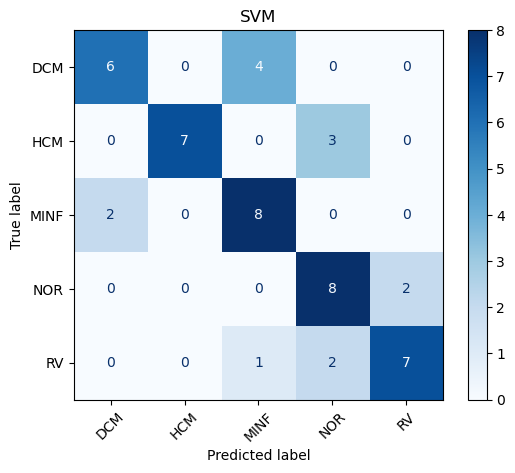

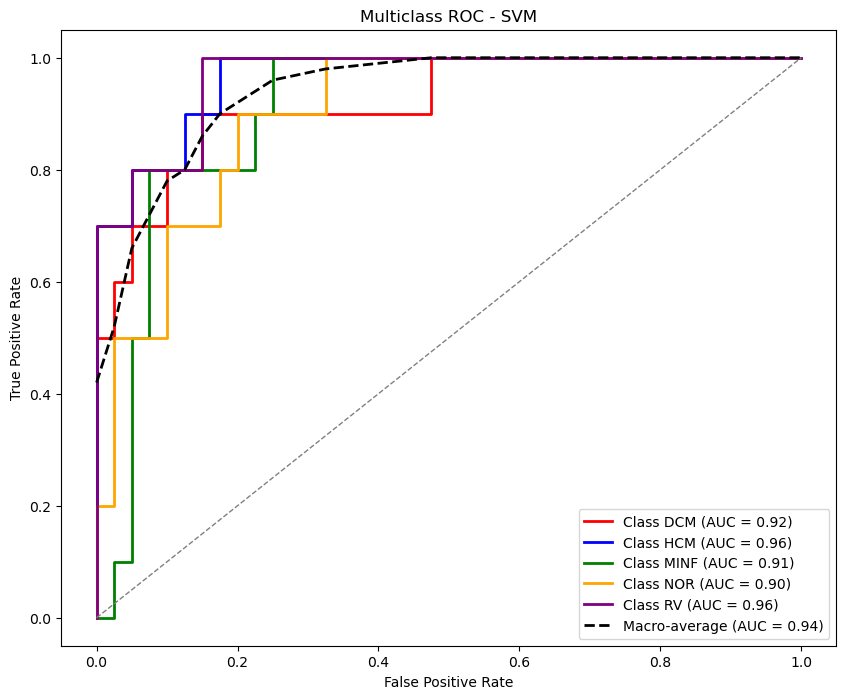


Best parameters for KNN: {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}


C:\Users\jonfe\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jonfe\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



Classification Report (KNN):
              precision    recall  f1-score   support

         DCM       0.60      0.60      0.60        10
         HCM       0.86      0.60      0.71        10
        MINF       0.64      0.70      0.67        10
         NOR       0.60      0.90      0.72        10
          RV       1.00      0.70      0.82        10

    accuracy                           0.70        50
   macro avg       0.74      0.70      0.70        50
weighted avg       0.74      0.70      0.70        50

Macro ROC-AUC (KNN): 0.93


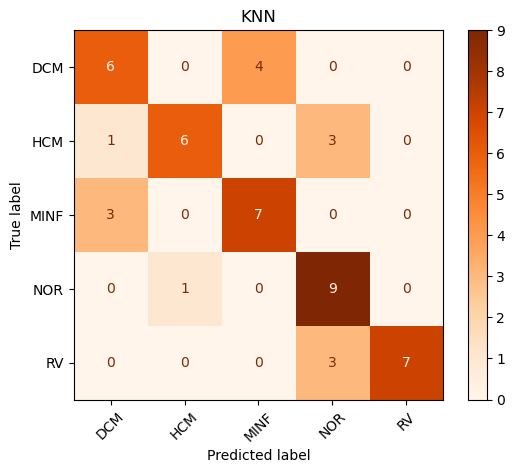

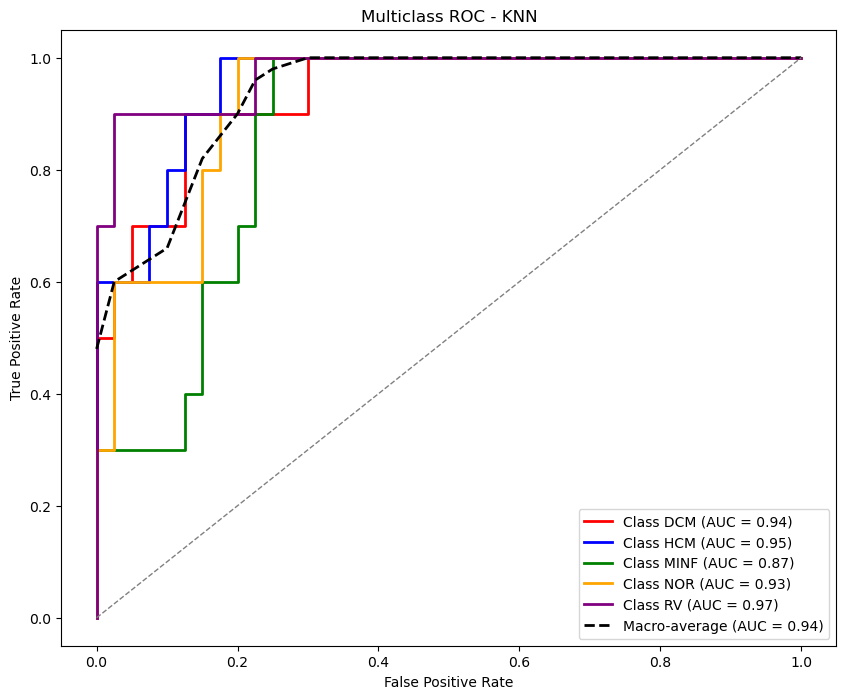


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report (Random Forest):
              precision    recall  f1-score   support

         DCM       0.67      0.60      0.63        10
         HCM       0.88      0.70      0.78        10
        MINF       0.56      0.50      0.53        10
         NOR       0.55      0.60      0.57        10
          RV       0.62      0.80      0.70        10

    accuracy                           0.64        50
   macro avg       0.65      0.64      0.64        50
weighted avg       0.65      0.64      0.64        50

Macro ROC-AUC (Random Forest): 0.92


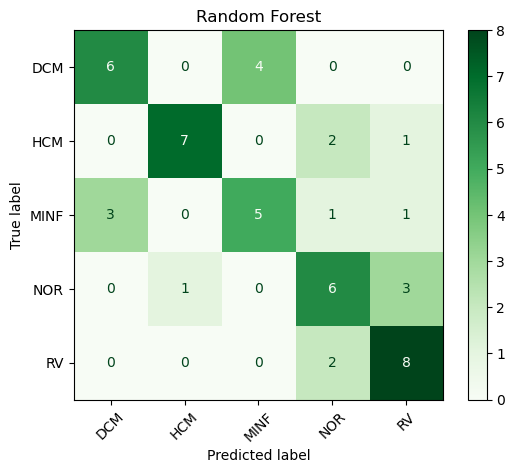

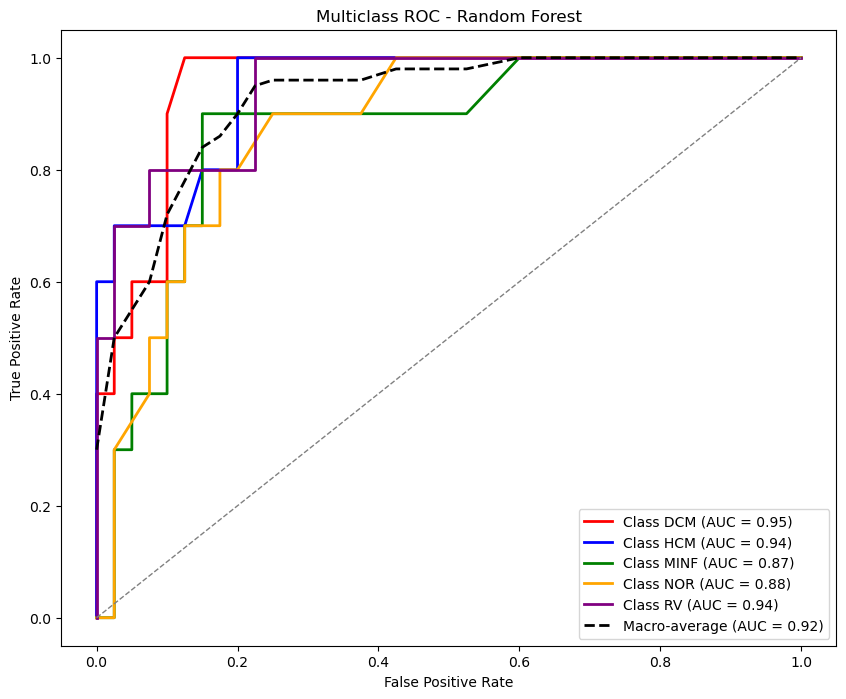


Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

         DCM       0.60      0.60      0.60        10
         HCM       1.00      0.30      0.46        10
        MINF       0.46      0.60      0.52        10
         NOR       0.50      0.70      0.58        10
          RV       0.80      0.80      0.80        10

    accuracy                           0.60        50
   macro avg       0.67      0.60      0.59        50
weighted avg       0.67      0.60      0.59        50

Macro ROC-AUC (Gradient Boosting): 0.84


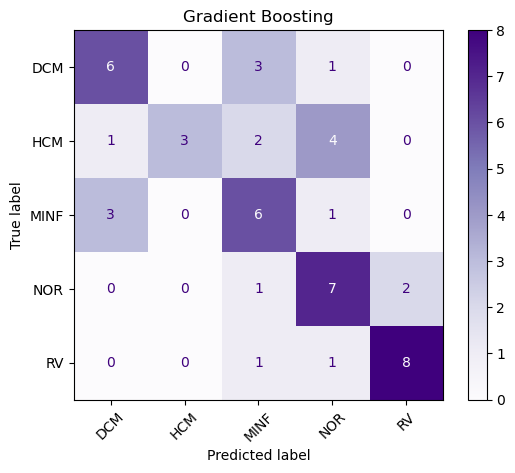

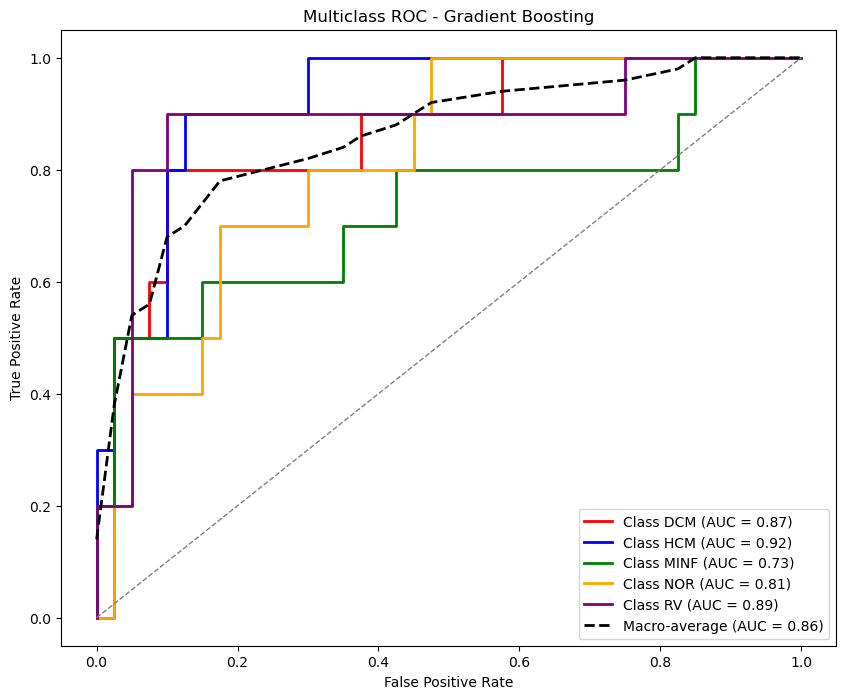


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Classification Report (XGBoost):
              precision    recall  f1-score   support

         DCM       0.86      0.60      0.71        10
         HCM       0.88      0.70      0.78        10
        MINF       0.60      0.60      0.60        10
         NOR       0.43      0.60      0.50        10
          RV       0.73      0.80      0.76        10

    accuracy                           0.66        50
   macro avg       0.70      0.66      0.67        50
weighted avg       0.70      0.66      0.67        50

Macro ROC-AUC (XGBoost): 0.87


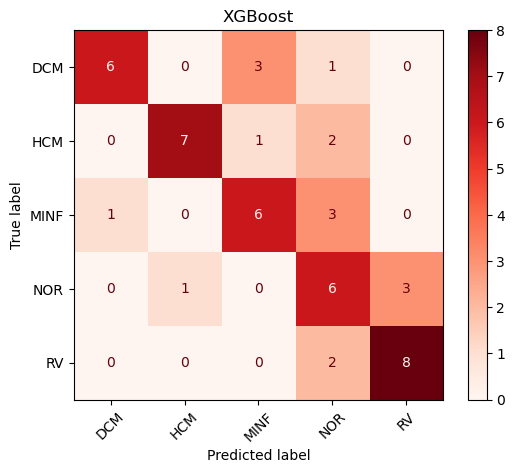

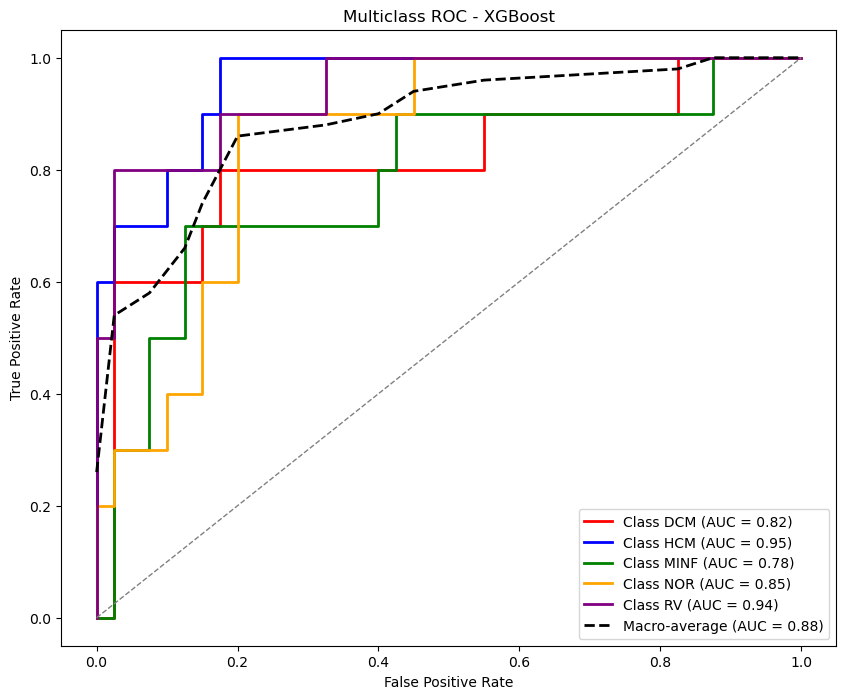

In [20]:
#ROUSEG classification with every feature
Classification_5Models(ROUSEG_train, ROUSEG_test, y_train, y_test)


Best parameters for SVM: {'C': 10, 'degree': 2, 'gamma': 0.01, 'kernel': 'sigmoid'}

Classification Report (SVM):
              precision    recall  f1-score   support

         DCM       1.00      0.50      0.67        10
         HCM       1.00      0.80      0.89        10
        MINF       0.67      1.00      0.80        10
         NOR       0.75      0.90      0.82        10
          RV       0.90      0.90      0.90        10

    accuracy                           0.82        50
   macro avg       0.86      0.82      0.81        50
weighted avg       0.86      0.82      0.81        50

Macro ROC-AUC (SVM): 0.94


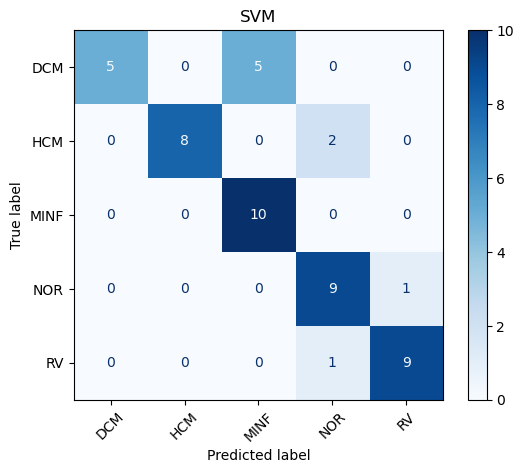

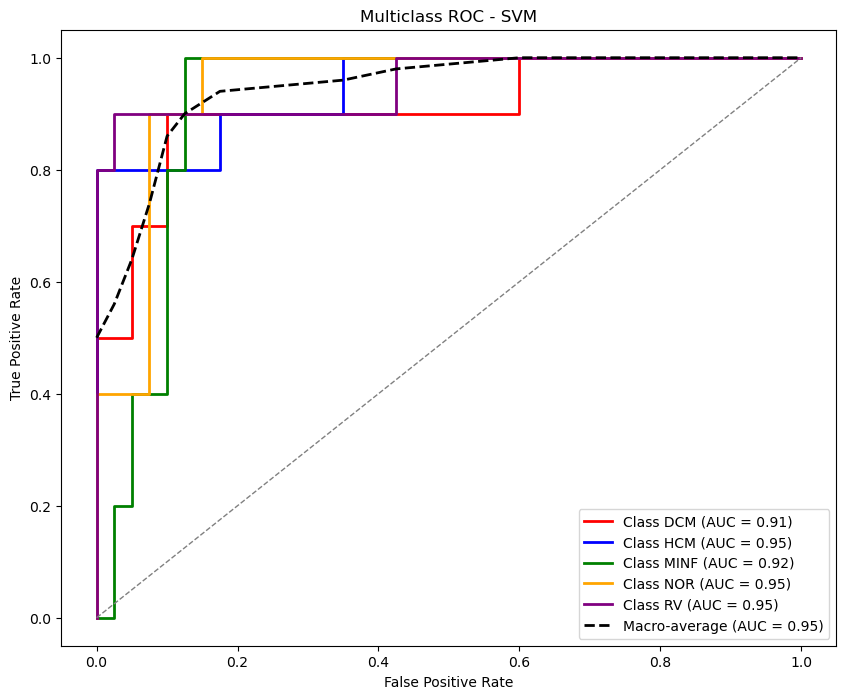


Best parameters for KNN: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

Classification Report (KNN):
              precision    recall  f1-score   support

         DCM       0.89      0.80      0.84        10
         HCM       0.88      0.70      0.78        10
        MINF       0.69      0.90      0.78        10
         NOR       0.83      1.00      0.91        10
          RV       0.88      0.70      0.78        10

    accuracy                           0.82        50
   macro avg       0.83      0.82      0.82        50
weighted avg       0.83      0.82      0.82        50

Macro ROC-AUC (KNN): 0.92


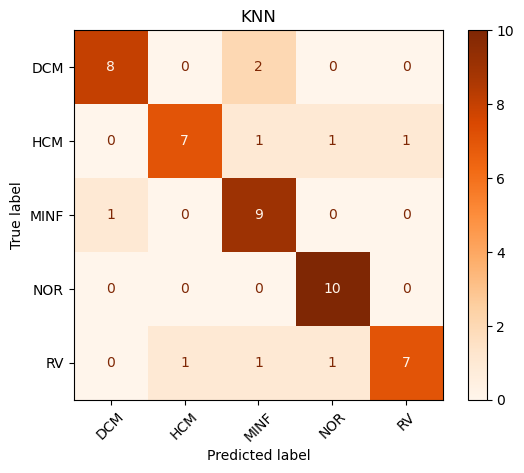

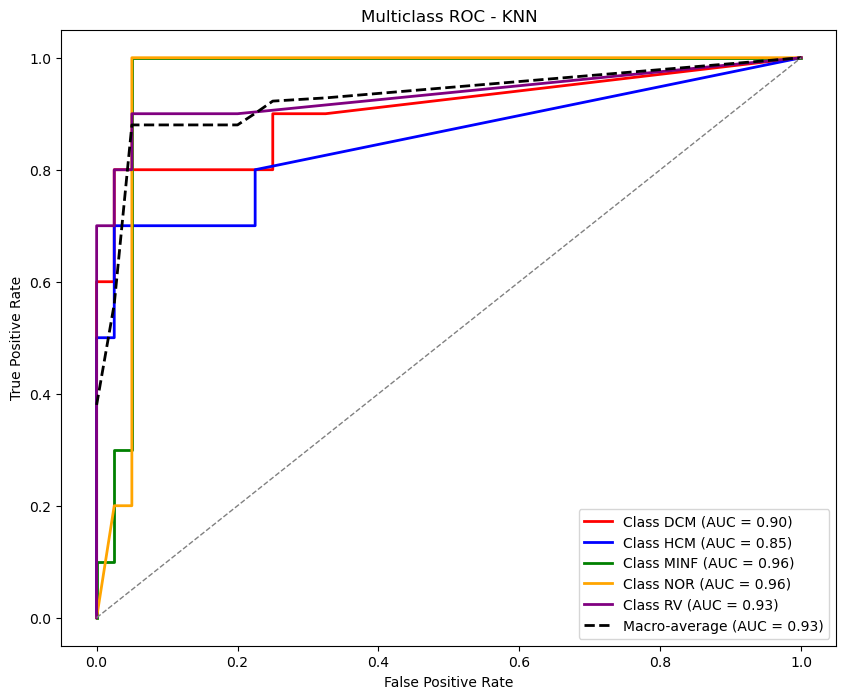


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report (Random Forest):
              precision    recall  f1-score   support

         DCM       0.67      0.60      0.63        10
         HCM       0.86      0.60      0.71        10
        MINF       0.56      0.50      0.53        10
         NOR       0.46      0.60      0.52        10
          RV       0.67      0.80      0.73        10

    accuracy                           0.62        50
   macro avg       0.64      0.62      0.62        50
weighted avg       0.64      0.62      0.62        50

Macro ROC-AUC (Random Forest): 0.93


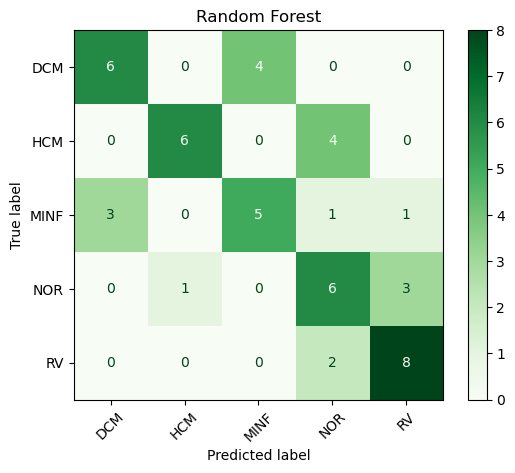

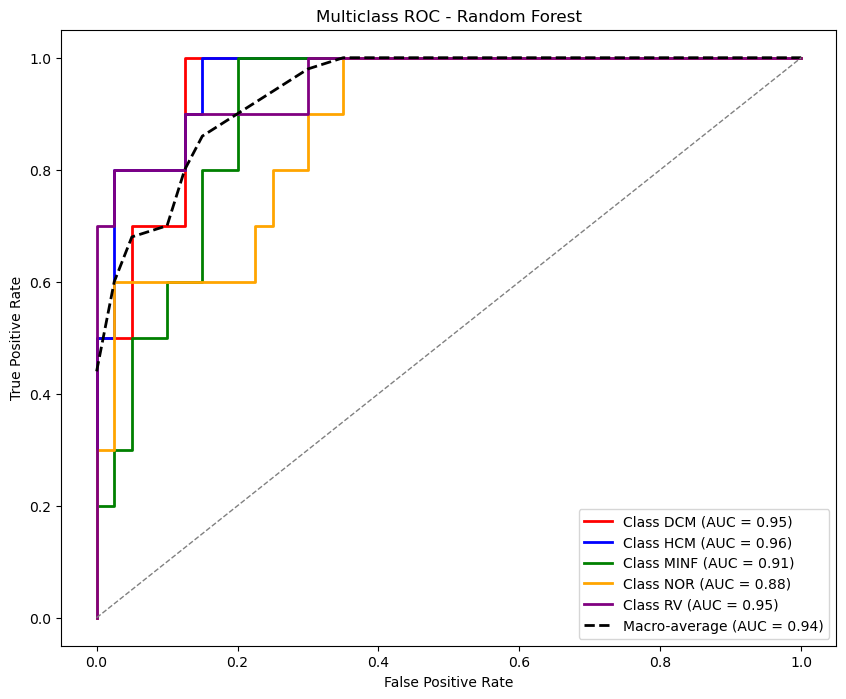


Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

         DCM       0.58      0.70      0.64        10
         HCM       1.00      0.30      0.46        10
        MINF       0.67      0.60      0.63        10
         NOR       0.58      0.70      0.64        10
          RV       0.57      0.80      0.67        10

    accuracy                           0.62        50
   macro avg       0.68      0.62      0.61        50
weighted avg       0.68      0.62      0.61        50

Macro ROC-AUC (Gradient Boosting): 0.84


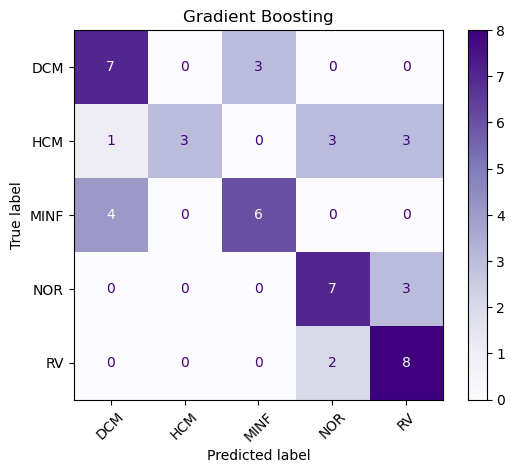

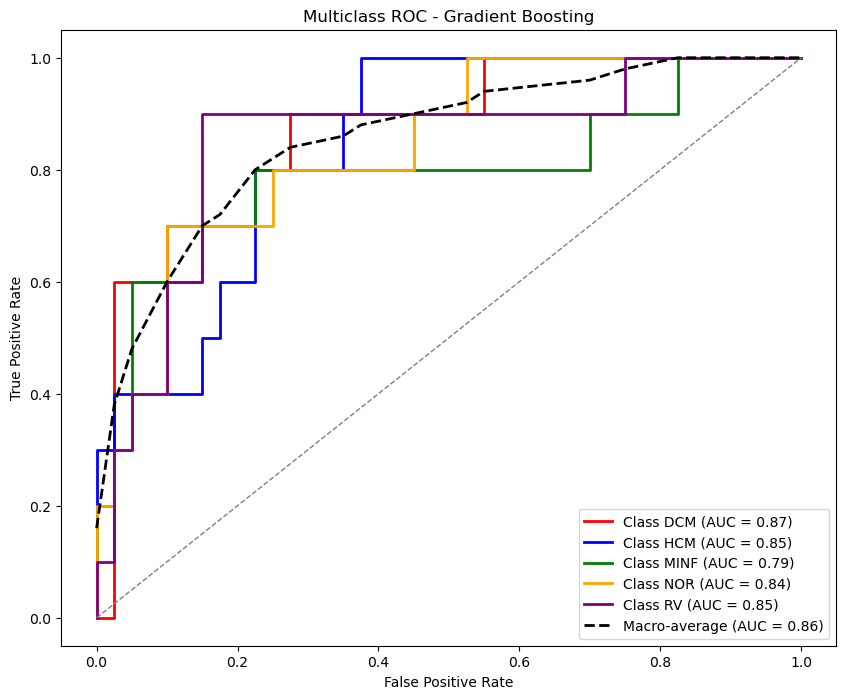


Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Classification Report (XGBoost):
              precision    recall  f1-score   support

         DCM       0.86      0.60      0.71        10
         HCM       0.88      0.70      0.78        10
        MINF       0.58      0.70      0.64        10
         NOR       0.50      0.60      0.55        10
          RV       0.73      0.80      0.76        10

    accuracy                           0.68        50
   macro avg       0.71      0.68      0.69        50
weighted avg       0.71      0.68      0.69        50

Macro ROC-AUC (XGBoost): 0.88


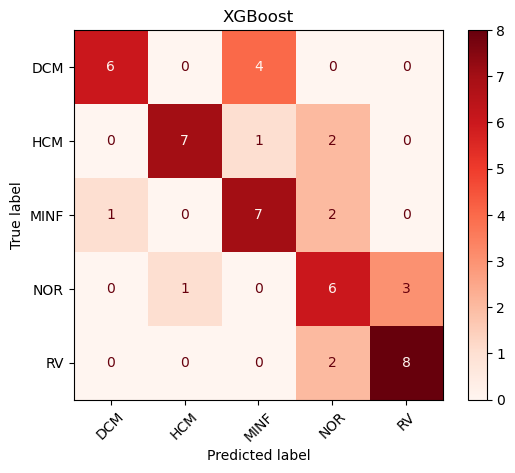

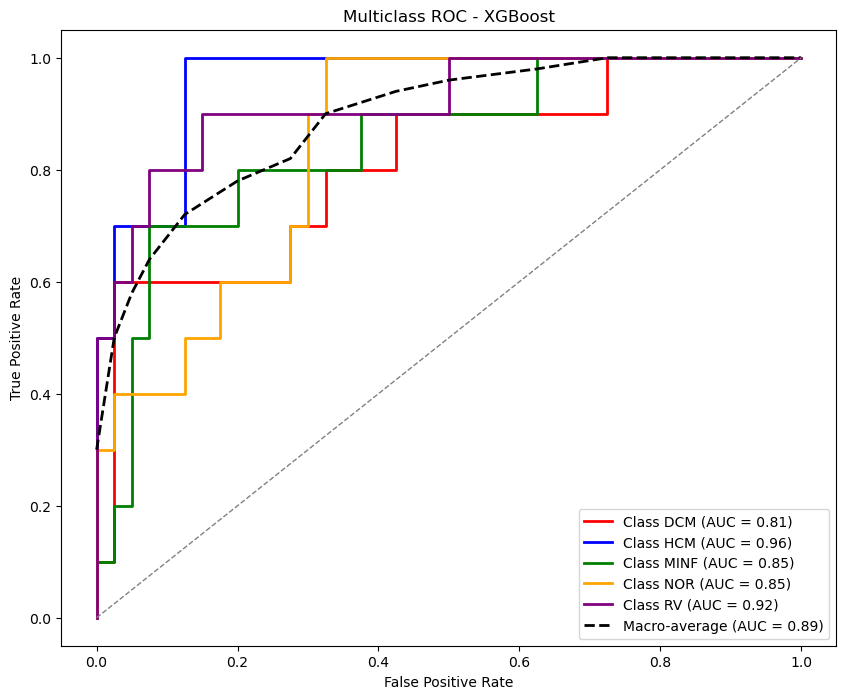

In [21]:
#ROUSEG classification with features with MI Score > 0.1
Classification_5Models(ROUSEG_train, ROUSEG_test, y_train, y_test, 42)


Best parameters for SVM: {'C': 10, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}

Classification Report (SVM):
              precision    recall  f1-score   support

         DCM       0.62      0.80      0.70        10
         HCM       0.83      0.50      0.62        10
        MINF       0.83      0.50      0.62        10
         NOR       0.45      0.50      0.48        10
          RV       0.57      0.80      0.67        10

    accuracy                           0.62        50
   macro avg       0.66      0.62      0.62        50
weighted avg       0.66      0.62      0.62        50

Macro ROC-AUC (SVM): 0.89


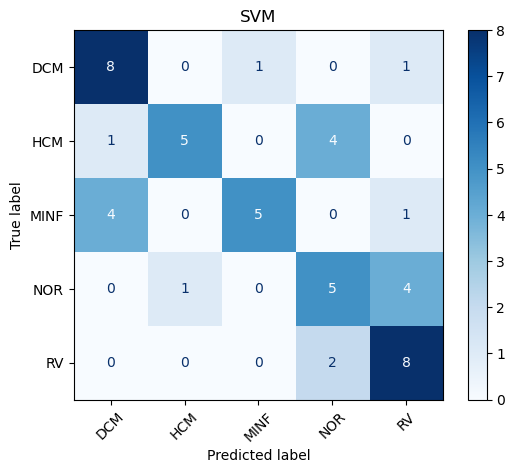

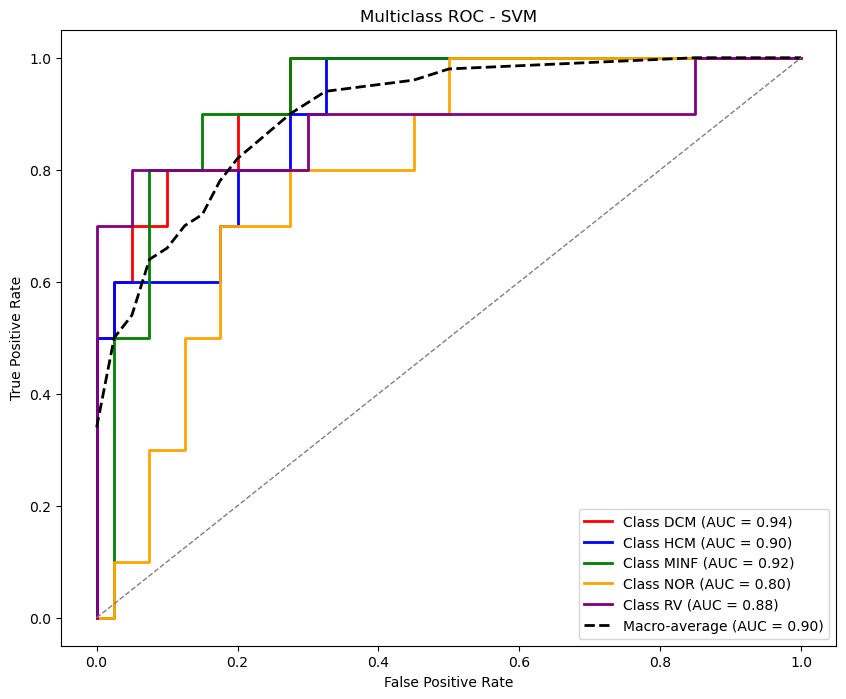


Best parameters for KNN: {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}

Classification Report (KNN):
              precision    recall  f1-score   support

         DCM       0.56      0.50      0.53        10
         HCM       1.00      0.50      0.67        10
        MINF       0.55      0.60      0.57        10
         NOR       0.47      0.70      0.56        10
          RV       0.70      0.70      0.70        10

    accuracy                           0.60        50
   macro avg       0.65      0.60      0.60        50
weighted avg       0.65      0.60      0.60        50

Macro ROC-AUC (KNN): 0.87


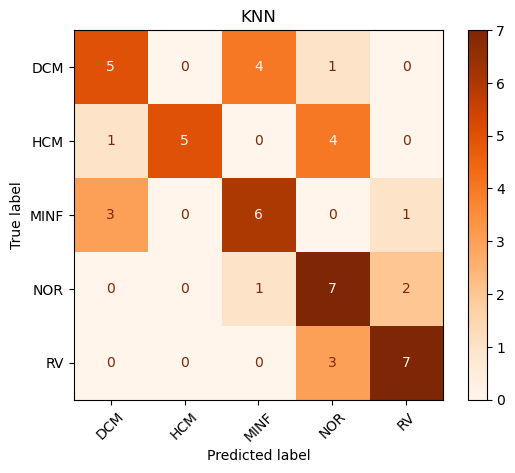

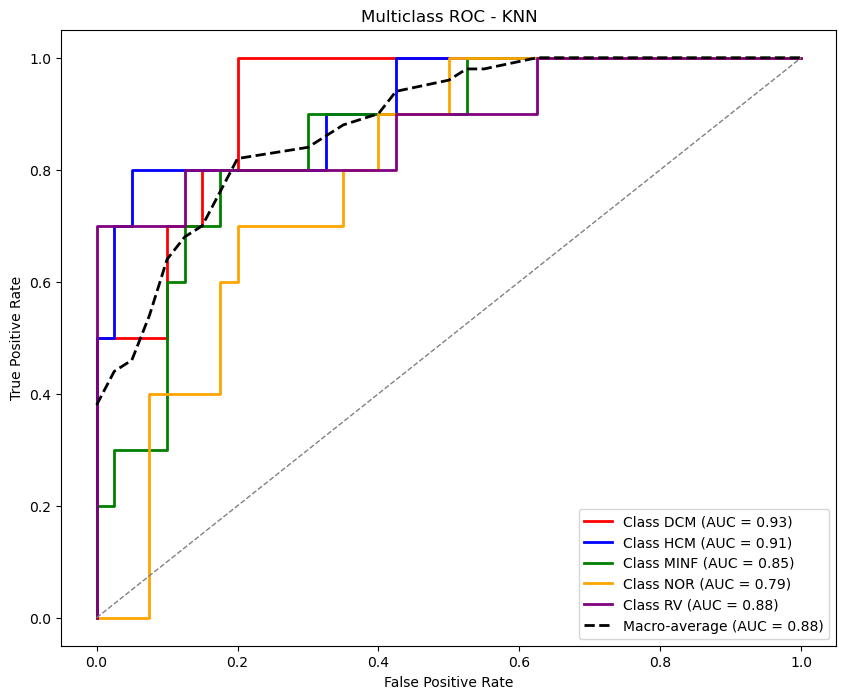


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

Classification Report (Random Forest):
              precision    recall  f1-score   support

         DCM       0.67      0.60      0.63        10
         HCM       0.71      0.50      0.59        10
        MINF       0.45      0.50      0.48        10
         NOR       0.54      0.70      0.61        10
          RV       0.80      0.80      0.80        10

    accuracy                           0.62        50
   macro avg       0.63      0.62      0.62        50
weighted avg       0.63      0.62      0.62        50

Macro ROC-AUC (Random Forest): 0.89


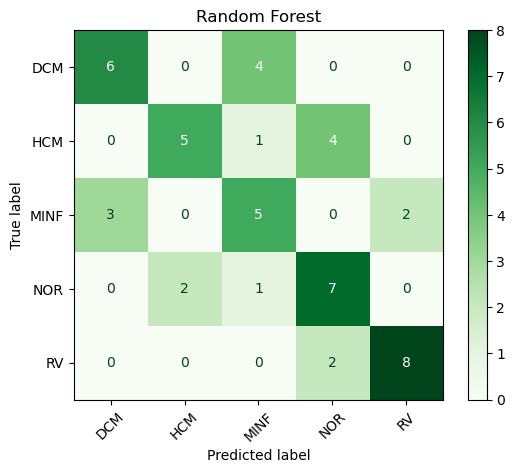

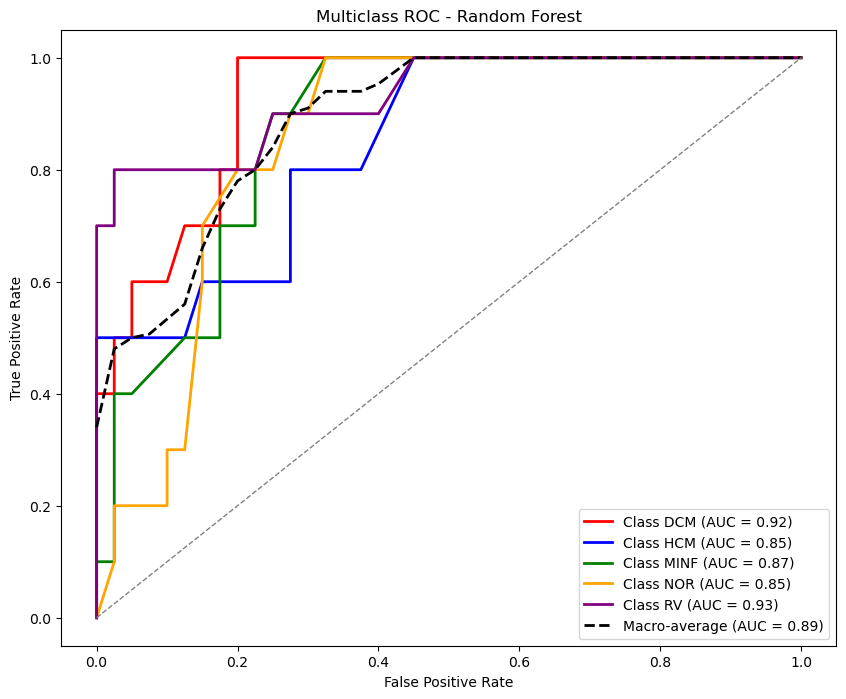


Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

         DCM       0.67      0.60      0.63        10
         HCM       0.60      0.60      0.60        10
        MINF       0.50      0.50      0.50        10
         NOR       0.40      0.40      0.40        10
          RV       0.73      0.80      0.76        10

    accuracy                           0.58        50
   macro avg       0.58      0.58      0.58        50
weighted avg       0.58      0.58      0.58        50

Macro ROC-AUC (Gradient Boosting): 0.82


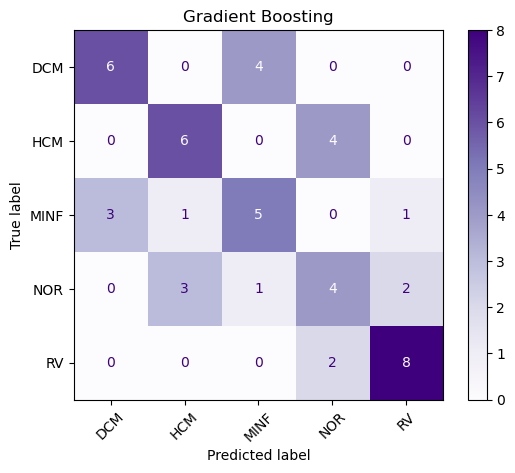

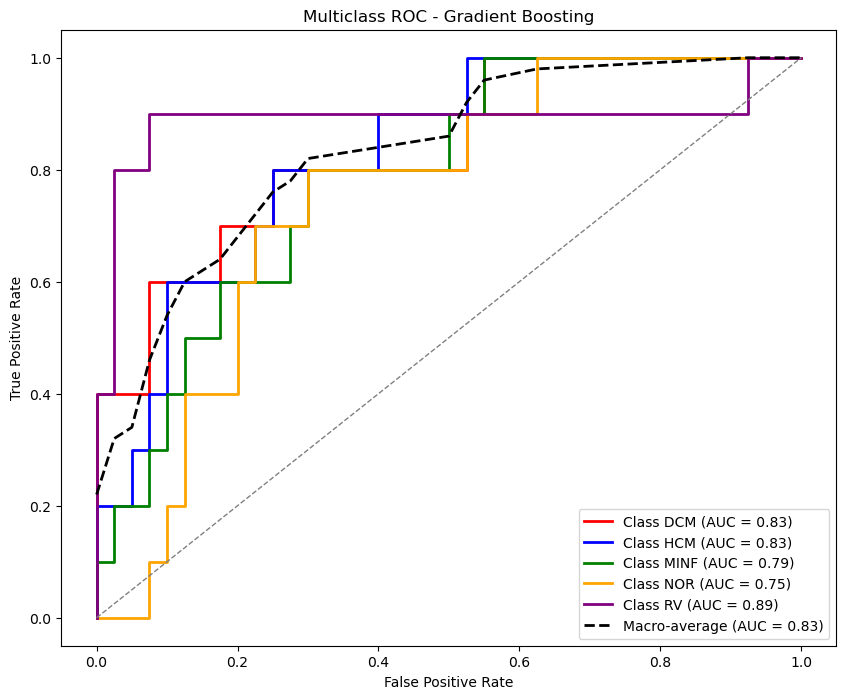


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Classification Report (XGBoost):
              precision    recall  f1-score   support

         DCM       0.56      0.50      0.53        10
         HCM       0.62      0.50      0.56        10
        MINF       0.50      0.50      0.50        10
         NOR       0.54      0.70      0.61        10
          RV       0.80      0.80      0.80        10

    accuracy                           0.60        50
   macro avg       0.60      0.60      0.60        50
weighted avg       0.60      0.60      0.60        50

Macro ROC-AUC (XGBoost): 0.87


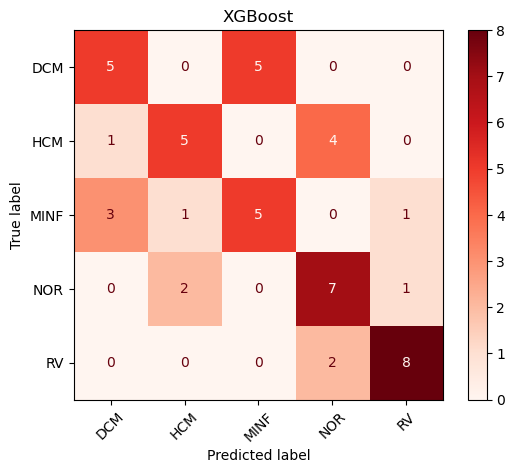

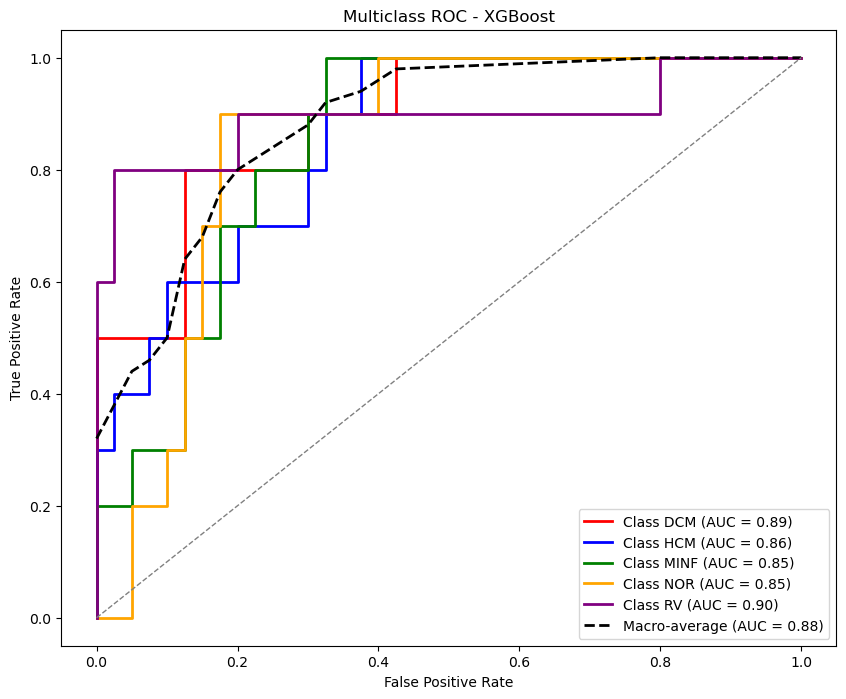

In [22]:
#NETSEG classification with every feature
Classification_5Models(NETSEG_train, NETSEG_test, y_train, y_test)


Best parameters for SVM: {'C': 1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}

Classification Report (SVM):
              precision    recall  f1-score   support

         DCM       0.50      0.70      0.58        10
         HCM       0.86      0.60      0.71        10
        MINF       0.62      0.50      0.56        10
         NOR       0.44      0.40      0.42        10
          RV       0.67      0.80      0.73        10

    accuracy                           0.60        50
   macro avg       0.62      0.60      0.60        50
weighted avg       0.62      0.60      0.60        50

Macro ROC-AUC (SVM): 0.91


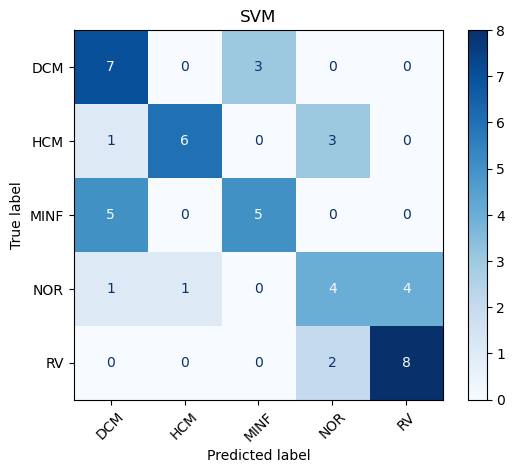

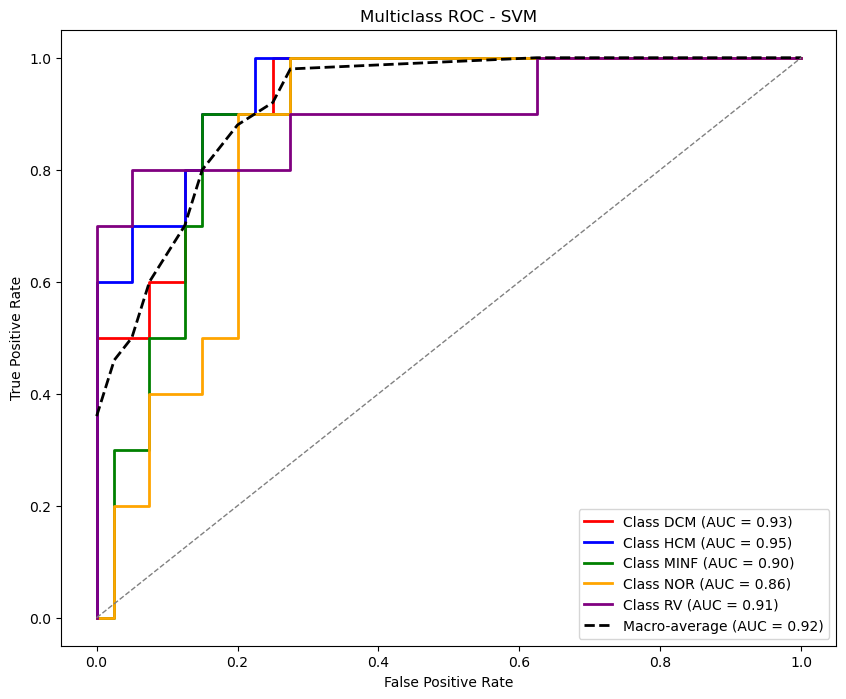


Best parameters for KNN: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

Classification Report (KNN):
              precision    recall  f1-score   support

         DCM       0.54      0.70      0.61        10
         HCM       0.90      0.90      0.90        10
        MINF       0.50      0.40      0.44        10
         NOR       0.64      0.70      0.67        10
          RV       0.88      0.70      0.78        10

    accuracy                           0.68        50
   macro avg       0.69      0.68      0.68        50
weighted avg       0.69      0.68      0.68        50

Macro ROC-AUC (KNN): 0.91


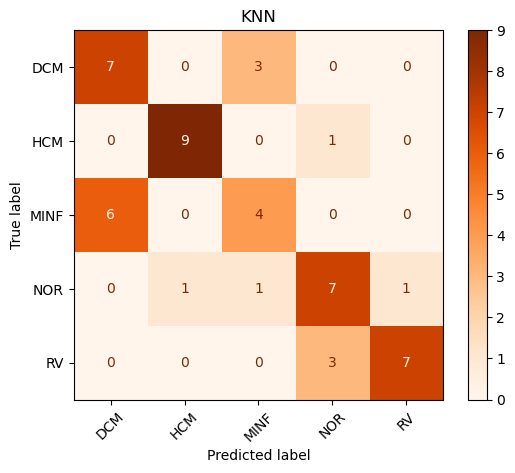

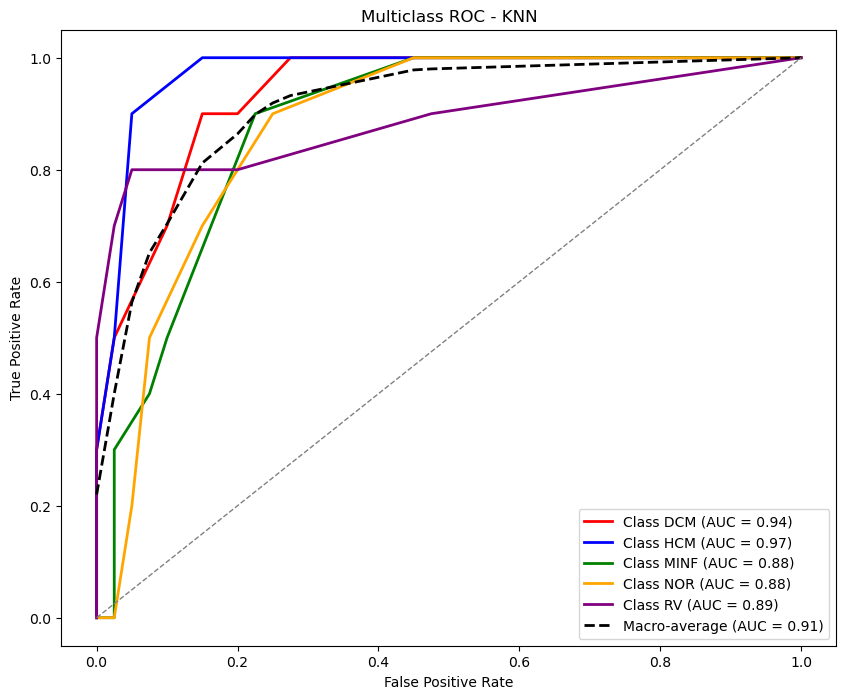


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report (Random Forest):
              precision    recall  f1-score   support

         DCM       0.56      0.50      0.53        10
         HCM       1.00      0.60      0.75        10
        MINF       0.50      0.60      0.55        10
         NOR       0.64      0.90      0.75        10
          RV       0.89      0.80      0.84        10

    accuracy                           0.68        50
   macro avg       0.72      0.68      0.68        50
weighted avg       0.72      0.68      0.68        50

Macro ROC-AUC (Random Forest): 0.92


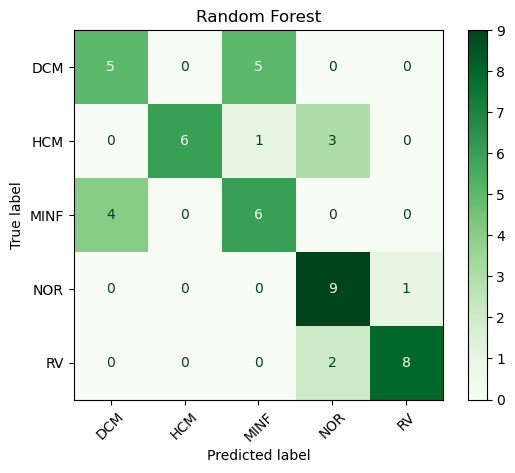

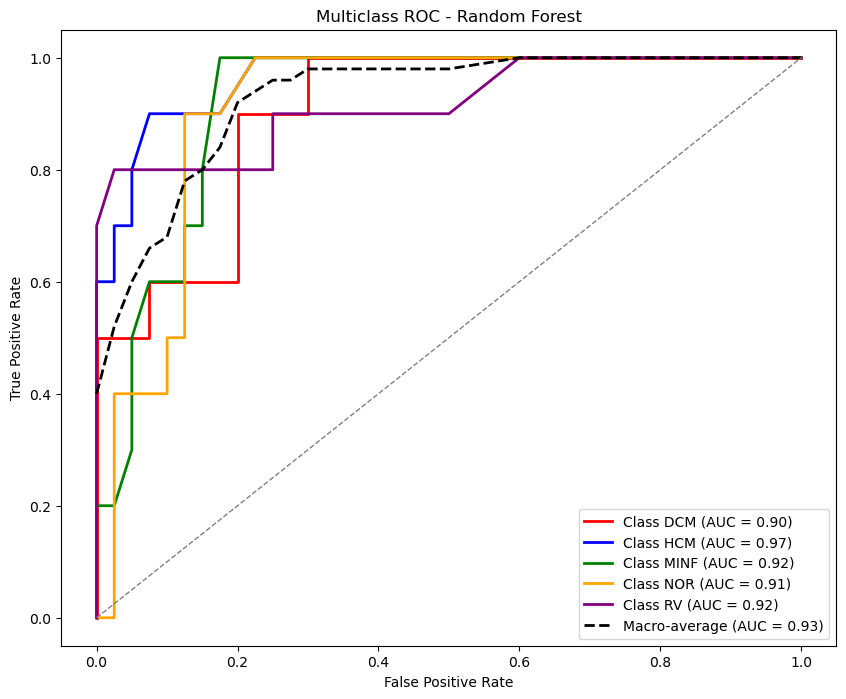


Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

         DCM       0.55      0.60      0.57        10
         HCM       0.60      0.60      0.60        10
        MINF       0.44      0.40      0.42        10
         NOR       0.45      0.50      0.48        10
          RV       0.89      0.80      0.84        10

    accuracy                           0.58        50
   macro avg       0.59      0.58      0.58        50
weighted avg       0.59      0.58      0.58        50

Macro ROC-AUC (Gradient Boosting): 0.83


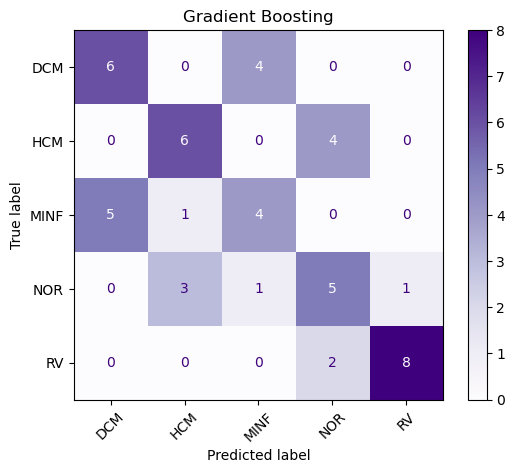

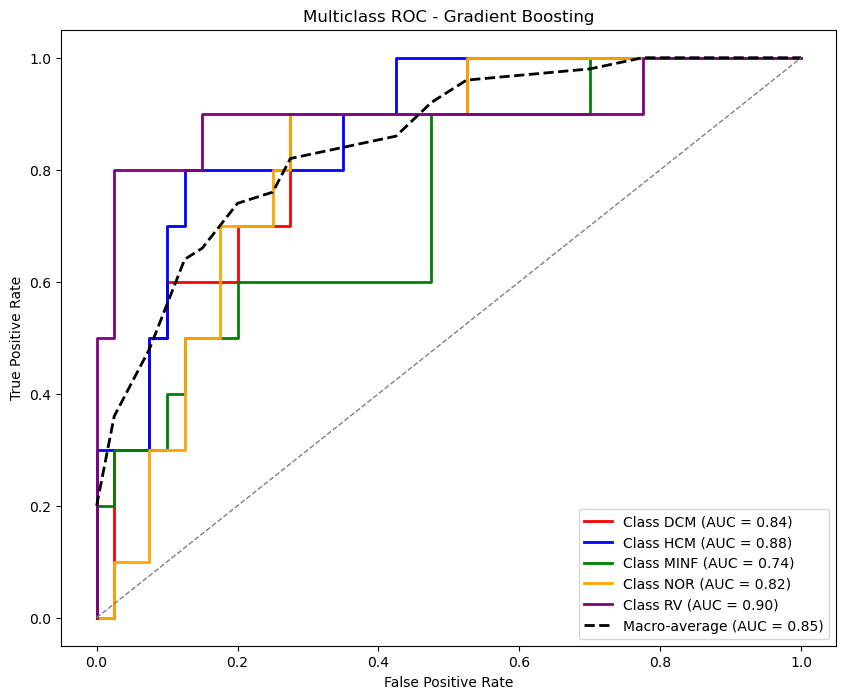


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Classification Report (XGBoost):
              precision    recall  f1-score   support

         DCM       0.56      0.50      0.53        10
         HCM       0.67      0.40      0.50        10
        MINF       0.50      0.50      0.50        10
         NOR       0.53      0.80      0.64        10
          RV       0.80      0.80      0.80        10

    accuracy                           0.60        50
   macro avg       0.61      0.60      0.59        50
weighted avg       0.61      0.60      0.59        50

Macro ROC-AUC (XGBoost): 0.87


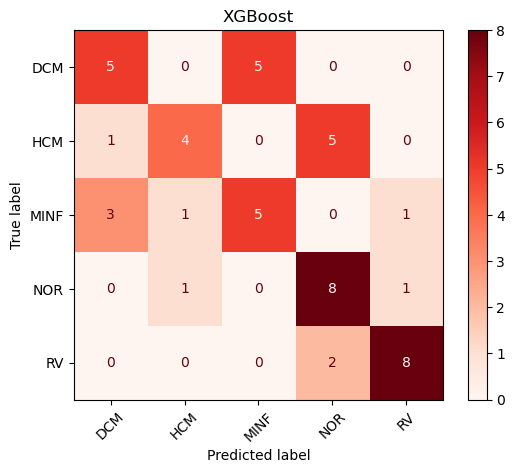

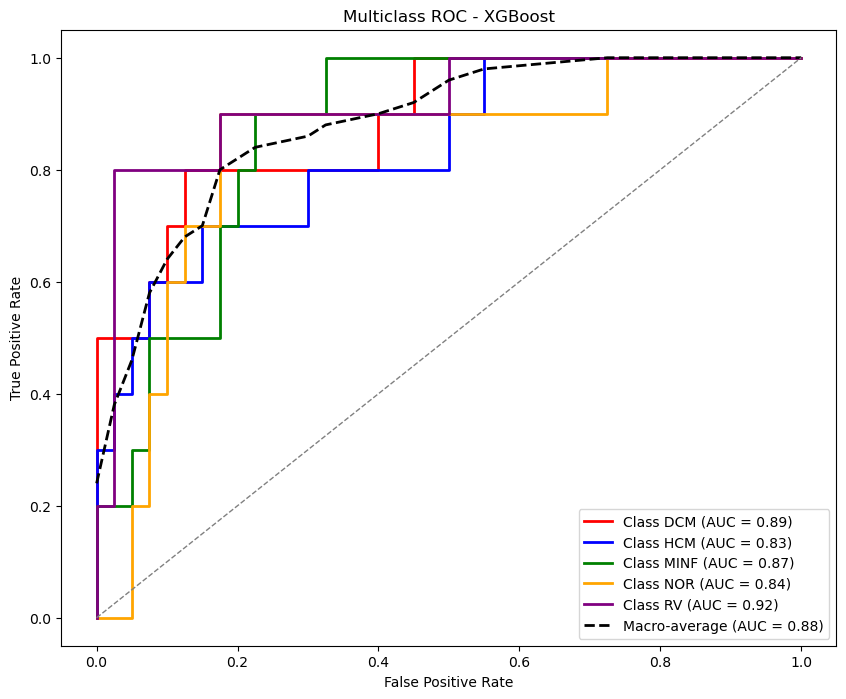

In [23]:
#NETSEG classification with features with MI Score > 0.1
Classification_5Models(NETSEG_train, NETSEG_test, y_train, y_test, 37)

In [26]:
# Function to trace the optimal selection of features
def Accuracy_5Models(X_train, X_test, y_train, y_test, features_list, n_splits=5):

    svm_met=[]
    knn_met=[]
    rf_met=[]
    gb_met=[]
    xgb_met=[]
    
    for k in range(1, len(features_list)):

        print(k)
    
        # Feature selection
        selector = SelectKBest(score_func=mutual_info_classif_fixed, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        selected_indices = selector.get_support(indices=True)
        X_test_selected = selector.transform(X_test)
    
        # SVM and KNN need scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)
    
        # Binarize for the ROC-AUC curve
        class_names = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']
        y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
    
        # 5-fold CV
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
        # SVM
        svm_params = {
            "C": [0.1, 1, 10, 100],
            "gamma": [0.0001, 0.001, 0.01, 0.1, 1],
            "kernel": ["linear", "rbf", "sigmoid", "poly"],
            "degree": [2,3,4]
        }
        svm_model = GridSearchCV(SVC(probability=True, random_state=42),
                                 param_grid=svm_params,
                                 cv=skf,
                                 scoring='accuracy',
                                 n_jobs=-1)
        svm_model.fit(X_train_scaled, y_train)
        print("\nBest parameters for SVM:", svm_model.best_params_)
        y_pred_svm = svm_model.predict(X_test_scaled)
        y_probs_svm = svm_model.predict_proba(X_test_scaled)
    
        print("\nClassification Report (SVM):")
        print(classification_report(y_test, y_pred_svm, target_names=class_names))
        svm_met.append([accuracy_score(y_test, y_pred_svm),f1_score(y_test, y_pred_svm,average='macro')])
        print(f"Macro ROC-AUC (SVM): {roc_auc_score(y_test_bin, y_probs_svm, average='macro'):.2f}")
    
        # KNN
        knn_params = {
            "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
            "weights": ["uniform", "distance"],
            "p": [1, 2]
        }
        knn_model = GridSearchCV(KNeighborsClassifier(),
                                 param_grid=knn_params,
                                 cv=skf,
                                 scoring='accuracy',
                                 n_jobs=-1)
        knn_model.fit(X_train_scaled, y_train)
        print("\nBest parameters for KNN:", knn_model.best_params_)
        y_pred_knn = knn_model.predict(X_test_scaled)
        y_probs_knn = knn_model.predict_proba(X_test_scaled)
    
        print("\nClassification Report (KNN):")
        print(classification_report(y_test, y_pred_knn, target_names=class_names))
        knn_met.append([accuracy_score(y_test, y_pred_knn),f1_score(y_test, y_pred_knn,average='macro')])
        print(f"Macro ROC-AUC (KNN): {roc_auc_score(y_test_bin, y_probs_knn, average='macro'):.2f}")
    
        # Random Forest
        rf_params = {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10]
        }
        rf_model = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_params,
                                cv=skf,
                                scoring='accuracy',
                                n_jobs=-1)
        rf_model.fit(X_train_selected, y_train)
        print("\nBest parameters for Random Forest:", rf_model.best_params_)
        y_pred_rf = rf_model.predict(X_test_selected)
        y_probs_rf = rf_model.predict_proba(X_test_selected)
    
        print("\nClassification Report (Random Forest):")
        print(classification_report(y_test, y_pred_rf, target_names=class_names))
        rf_met.append([accuracy_score(y_test, y_pred_rf),f1_score(y_test, y_pred_rf, average='macro')])
        print(f"Macro ROC-AUC (Random Forest): {roc_auc_score(y_test_bin, y_probs_rf, average='macro'):.2f}")
    
        # Gradient Boosting
        gb_params = {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
        gb_model = GridSearchCV(GradientBoostingClassifier(random_state=42),
                                param_grid=gb_params,
                                cv=skf,
                                scoring='accuracy',
                                n_jobs=-1)
        gb_model.fit(X_train_selected, y_train)
        print("\nBest parameters for Gradient Boosting:", gb_model.best_params_)
        y_pred_gb = gb_model.predict(X_test_selected)
        y_probs_gb = gb_model.predict_proba(X_test_selected)
    
        print("\nClassification Report (Gradient Boosting):")
        print(classification_report(y_test, y_pred_gb, target_names=class_names))
        gb_met.append([accuracy_score(y_test, y_pred_gb),f1_score(y_test, y_pred_gb,average='macro')])
        print(f"Macro ROC-AUC (Gradient Boosting): {roc_auc_score(y_test_bin, y_probs_gb, average='macro'):.2f}")
    
        # XGBoost
        xgb_params = {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
        xgb_model = GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'),
                                 param_grid=xgb_params,
                                 cv=skf,
                                 scoring='accuracy',
                                 n_jobs=-1)
        xgb_model.fit(X_train_selected, y_train)
        print("\nBest parameters for XGBoost:", xgb_model.best_params_)
        y_pred_xgb = xgb_model.predict(X_test_selected)
        y_probs_xgb = xgb_model.predict_proba(X_test_selected)
    
        print("\nClassification Report (XGBoost):")
        print(classification_report(y_test, y_pred_xgb, target_names=class_names))
        xgb_met.append([accuracy_score(y_test, y_pred_xgb),f1_score(y_test, y_pred_xgb,average='macro')])
        print(f"Macro ROC-AUC (XGBoost): {roc_auc_score(y_test_bin, y_probs_xgb, average='macro'):.2f}")

    return svm_met, knn_met, rf_met, gb_met, xgb_met 

In [66]:
# We now define individual functions for each model for convenience
def Classification_SVM(X_train, X_test, y_train, y_test, k=len(features_list), n_splits=5):
    
    # Feature selection
    selector = SelectKBest(score_func=mutual_info_classif_fixed, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    selected_indices = selector.get_support(indices=True)
    X_test_selected = selector.transform(X_test)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Binarize for the ROC-AUC curve
    class_names = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']
    y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

    # 5-fold CV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # SVM
    svm_params = {
        "C": [0.1, 1, 10, 100],
        "gamma": [0.0001, 0.001, 0.01, 0.1, 1],
        "kernel": ["linear", "rbf", "sigmoid", "poly"],
        "degree": [2,3,4]
    }
    svm_model = GridSearchCV(SVC(probability=True, random_state=42),
                             param_grid=svm_params,
                             cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    svm_model.fit(X_train_scaled, y_train)
    print("\nBest parameters for SVM:", svm_model.best_params_)
    y_pred_svm = svm_model.predict(X_test_scaled)
    y_probs_svm = svm_model.predict_proba(X_test_scaled)

    print("\nClassification Report (SVM):")
    print(classification_report(y_test, y_pred_svm, target_names=class_names))
    print(f"Macro ROC-AUC (SVM): {roc_auc_score(y_test_bin, y_probs_svm, average='macro'):.2f}")
    conf_matrix(y_test, y_pred_svm, "SVM", plt.cm.Blues)
    plot_multiclass_roc(y_test_bin, y_probs_svm, class_names, "SVM")

def Classification_KNN(X_train, X_test, y_train, y_test, k=len(features_list), n_splits=5):
    
    # Feature selection
    selector = SelectKBest(score_func=mutual_info_classif_fixed, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    selected_indices = selector.get_support(indices=True)
    X_test_selected = selector.transform(X_test)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Binarize for the ROC-AUC curve
    class_names = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']
    y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

    # 5-fold CV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # KNN
    knn_params = {
        "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
        "weights": ["uniform", "distance"],
        "p": [1, 2]
    }
    knn_model = GridSearchCV(KNeighborsClassifier(),
                             param_grid=knn_params,
                             cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    knn_model.fit(X_train_scaled, y_train)
    print("\nBest parameters for KNN:", knn_model.best_params_)
    y_pred_knn = knn_model.predict(X_test_scaled)
    y_probs_knn = knn_model.predict_proba(X_test_scaled)

    print("\nClassification Report (KNN):")
    print(classification_report(y_test, y_pred_knn, target_names=class_names))
    print(f"Macro ROC-AUC (KNN): {roc_auc_score(y_test_bin, y_probs_knn, average='macro'):.2f}")
    conf_matrix(y_test, y_pred_knn, "KNN", plt.cm.Oranges)
    plot_multiclass_roc(y_test_bin, y_probs_knn, class_names, "KNN")

def Classification_RF(X_train, X_test, y_train, y_test, k=len(features_list), n_splits=5):
    
    # Feature selection
    selector = SelectKBest(score_func=mutual_info_classif_fixed, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    selected_indices = selector.get_support(indices=True)
    X_test_selected = selector.transform(X_test)

    # Binarize for the ROC-AUC curve
    class_names = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']
    y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

    # 5-fold CV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Random Forest
    rf_params = {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    }
    rf_model = GridSearchCV(RandomForestClassifier(random_state=42),
                            param_grid=rf_params,
                            cv=skf,
                            scoring='accuracy',
                            n_jobs=-1)
    rf_model.fit(X_train_selected, y_train)
    print("\nBest parameters for Random Forest:", rf_model.best_params_)
    y_pred_rf = rf_model.predict(X_test_selected)
    y_probs_rf = rf_model.predict_proba(X_test_selected)

    print("\nClassification Report (Random Forest):")
    print(classification_report(y_test, y_pred_rf, target_names=class_names))
    print(f"Macro ROC-AUC (Random Forest): {roc_auc_score(y_test_bin, y_probs_rf, average='macro'):.2f}")
    conf_matrix(y_test, y_pred_rf, "Random Forest", plt.cm.Greens)
    plot_multiclass_roc(y_test_bin, y_probs_rf, class_names, "Random Forest")

def Classification_GB(X_train, X_test, y_train, y_test, k=len(features_list), n_splits=5):
    
    # Feature selection
    selector = SelectKBest(score_func=mutual_info_classif_fixed, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    selected_indices = selector.get_support(indices=True)
    X_test_selected = selector.transform(X_test)

    # SVM and KNN need scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Binarize for the ROC-AUC curve
    class_names = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']
    y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

    # 5-fold CV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Gradient Boosting
    gb_params = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    }
    gb_model = GridSearchCV(GradientBoostingClassifier(random_state=42),
                            param_grid=gb_params,
                            cv=skf,
                            scoring='accuracy',
                            n_jobs=-1)
    gb_model.fit(X_train_selected, y_train)
    print("\nBest parameters for Gradient Boosting:", gb_model.best_params_)
    y_pred_gb = gb_model.predict(X_test_selected)
    y_probs_gb = gb_model.predict_proba(X_test_selected)

    print("\nClassification Report (Gradient Boosting):")
    print(classification_report(y_test, y_pred_gb, target_names=class_names))
    print(f"Macro ROC-AUC (Gradient Boosting): {roc_auc_score(y_test_bin, y_probs_gb, average='macro'):.2f}")
    conf_matrix(y_test, y_pred_gb, "Gradient Boosting", plt.cm.Purples)
    plot_multiclass_roc(y_test_bin, y_probs_gb, class_names, "Gradient Boosting")

def Classification_XGB(X_train, X_test, y_train, y_test, k=len(features_list), n_splits=5):
    
    # Feature selection
    selector = SelectKBest(score_func=mutual_info_classif_fixed, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    selected_indices = selector.get_support(indices=True)
    X_test_selected = selector.transform(X_test)

    # Binarize for the ROC-AUC curve
    class_names = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']
    y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

    # 5-fold CV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # XGBoost
    xgb_params = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    }
    xgb_model = GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'),
                             param_grid=xgb_params,
                             cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    xgb_model.fit(X_train_selected, y_train)
    print("\nBest parameters for XGBoost:", xgb_model.best_params_)
    y_pred_xgb = xgb_model.predict(X_test_selected)
    y_probs_xgb = xgb_model.predict_proba(X_test_selected)

    print("\nClassification Report (XGBoost):")
    print(classification_report(y_test, y_pred_xgb, target_names=class_names))
    print(f"Macro ROC-AUC (XGBoost): {roc_auc_score(y_test_bin, y_probs_xgb, average='macro'):.2f}")
    conf_matrix(y_test, y_pred_xgb, "XGBoost", plt.cm.Reds)
    plot_multiclass_roc(y_test_bin, y_probs_xgb, class_names, "XGBoost")

Here we calculate the optimal selection of features for each model in ROUSEG

In [27]:
ROUSEG_svm, ROUSEG_knn, ROUSEG_rf, ROUSEG_gb, ROUSEG_xgb = Accuracy_5Models(ROUSEG_train,ROUSEG_test,y_train,y_test,features_list)

1

Best parameters for SVM: {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}

Classification Report (SVM):
              precision    recall  f1-score   support

         DCM       0.73      0.80      0.76        10
         HCM       0.50      0.80      0.62        10
        MINF       0.38      0.60      0.46        10
         NOR       0.25      0.10      0.14        10
          RV       0.00      0.00      0.00        10

    accuracy                           0.46        50
   macro avg       0.37      0.46      0.40        50
weighted avg       0.37      0.46      0.40        50

Macro ROC-AUC (SVM): 0.74

Best parameters for KNN: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

Classification Report (KNN):
              precision    recall  f1-score   support

         DCM       0.70      0.70      0.70        10
         HCM       0.15      0.20      0.17        10
        MINF       0.71      0.50      0.59        10
         NOR       0.17      0.20      0.18        1

In [49]:
# This gets the highest accuracy, and if there is a repetition it takes the highest f1-score
# We could directly return the number of features, but we prefer printing it first.
def get_best(listofduplets):

    max_accuracy = max(listofduplets, key=lambda x: x[0])[0]
    filtered = [d for d in listofduplets if d[0] == max_accuracy]
    acc_f1score = max(filtered, key=lambda x: x[1])
    index = listofduplets.index(acc_f1score)
    
    print(f"Best Accuracy-F1Score: {acc_f1score}")
    print(f"Number of features: {index+1}")

In [30]:
get_best(ROUSEG_svm)

Best Accuracy-F1Score: [0.82, 0.8186004653577678]
Number of features: 39



Best parameters for SVM: {'C': 10, 'degree': 2, 'gamma': 0.01, 'kernel': 'sigmoid'}

Classification Report (SVM):
              precision    recall  f1-score   support

         DCM       0.86      0.60      0.71        10
         HCM       1.00      0.90      0.95        10
        MINF       0.69      0.90      0.78        10
         NOR       0.80      0.80      0.80        10
          RV       0.82      0.90      0.86        10

    accuracy                           0.82        50
   macro avg       0.83      0.82      0.82        50
weighted avg       0.83      0.82      0.82        50

Macro ROC-AUC (SVM): 0.95


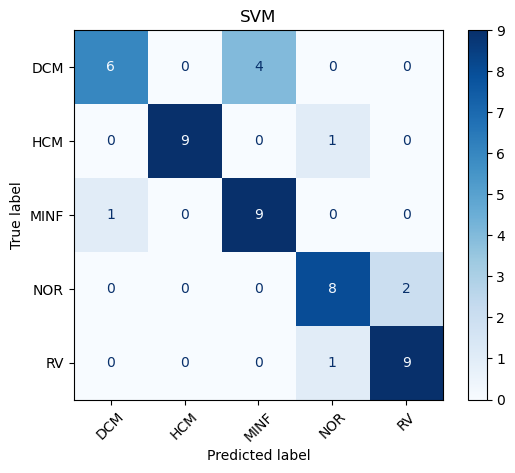

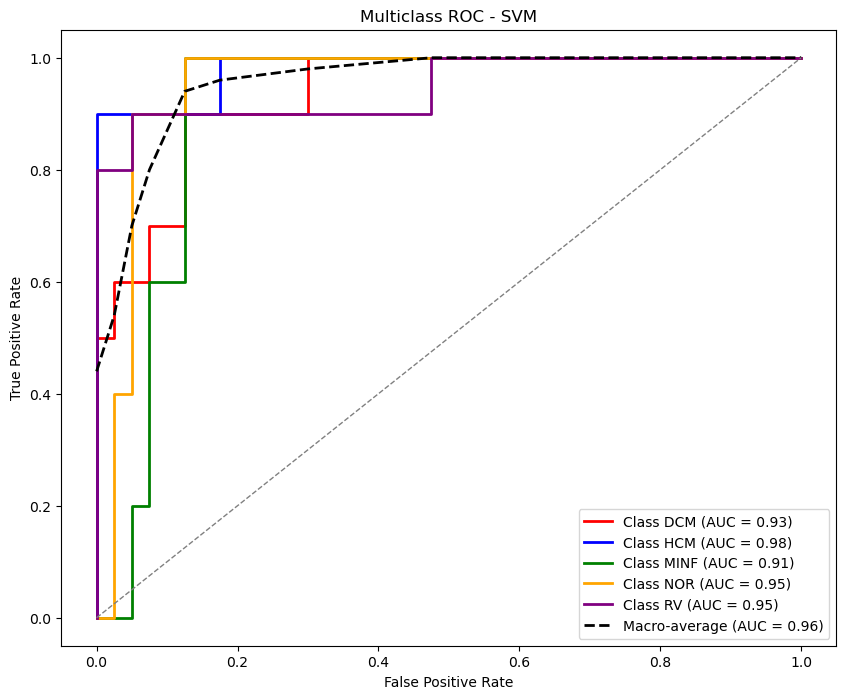

In [36]:
# Optimal ROUSEG SVM
Classification_SVM(ROUSEG_train, ROUSEG_test, y_train, y_test, k=39)

In [32]:
get_best(ROUSEG_knn)

Best Accuracy-F1Score: [0.82, 0.8178720846913066]
Number of features: 42


The optimal KNN is the one with threshold selection

In [33]:
get_best(ROUSEG_rf)

Best Accuracy-F1Score: [0.68, 0.6857142857142857]
Number of features: 59



Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report (Random Forest):
              precision    recall  f1-score   support

         DCM       0.75      0.60      0.67        10
         HCM       1.00      0.60      0.75        10
        MINF       0.64      0.70      0.67        10
         NOR       0.50      0.70      0.58        10
          RV       0.73      0.80      0.76        10

    accuracy                           0.68        50
   macro avg       0.72      0.68      0.69        50
weighted avg       0.72      0.68      0.69        50

Macro ROC-AUC (Random Forest): 0.92


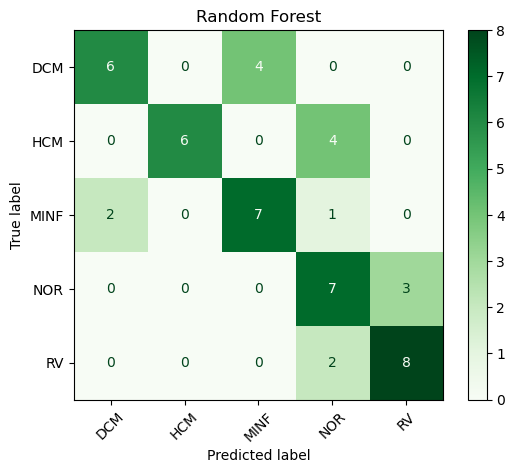

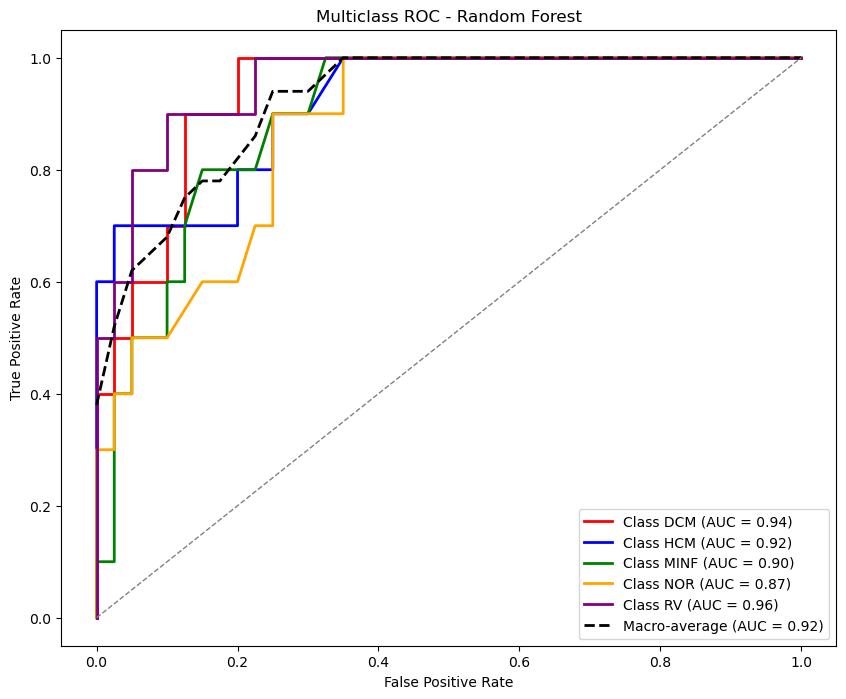

In [37]:
# Optimal ROUSEG RF
Classification_RF(ROUSEG_train, ROUSEG_test, y_train, y_test, k=59)

In [34]:
get_best(ROUSEG_gb)

Best Accuracy-F1Score: [0.7, 0.7030903461863215]
Number of features: 23



Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

         DCM       0.86      0.60      0.71        10
         HCM       0.78      0.70      0.74        10
        MINF       0.58      0.70      0.64        10
         NOR       0.58      0.70      0.64        10
          RV       0.80      0.80      0.80        10

    accuracy                           0.70        50
   macro avg       0.72      0.70      0.70        50
weighted avg       0.72      0.70      0.70        50

Macro ROC-AUC (Gradient Boosting): 0.88


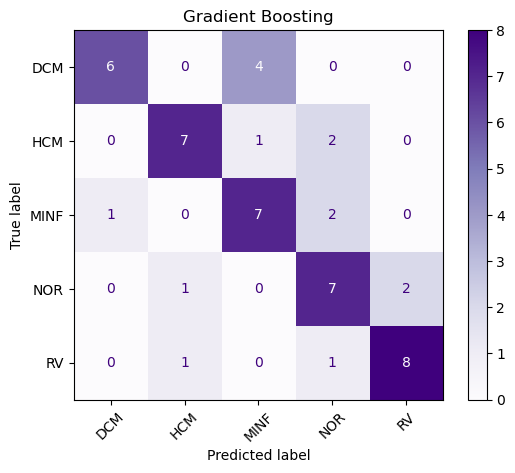

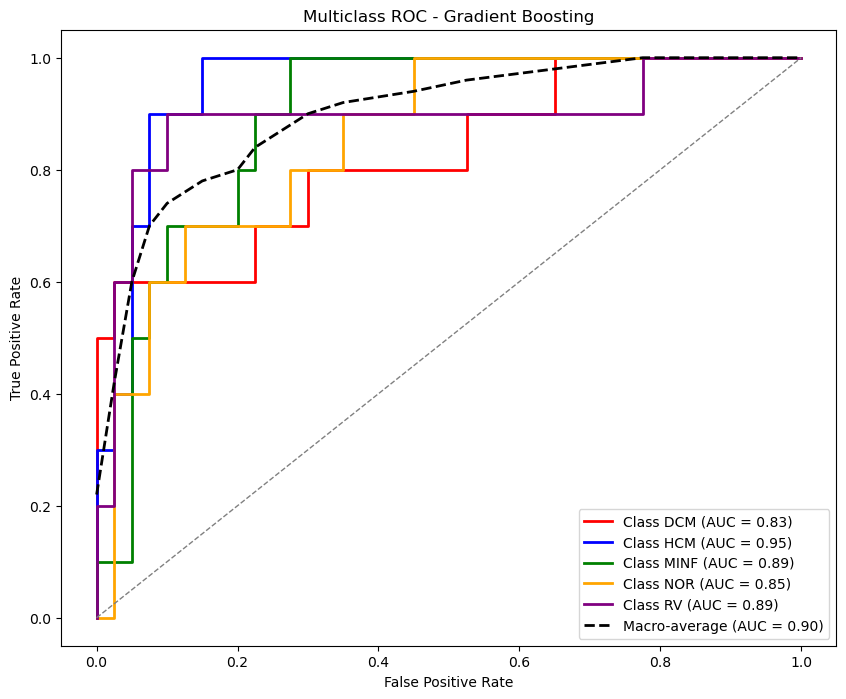

In [39]:
# Optimal ROUSEG GB
Classification_GB(ROUSEG_train, ROUSEG_test, y_train, y_test, k=23)

In [35]:
get_best(ROUSEG_xgb)

Best Accuracy-F1Score: [0.72, 0.7264884135472369]
Number of features: 56



Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

Classification Report (XGBoost):
              precision    recall  f1-score   support

         DCM       0.86      0.60      0.71        10
         HCM       1.00      0.70      0.82        10
        MINF       0.58      0.70      0.64        10
         NOR       0.57      0.80      0.67        10
          RV       0.80      0.80      0.80        10

    accuracy                           0.72        50
   macro avg       0.76      0.72      0.73        50
weighted avg       0.76      0.72      0.73        50

Macro ROC-AUC (XGBoost): 0.88


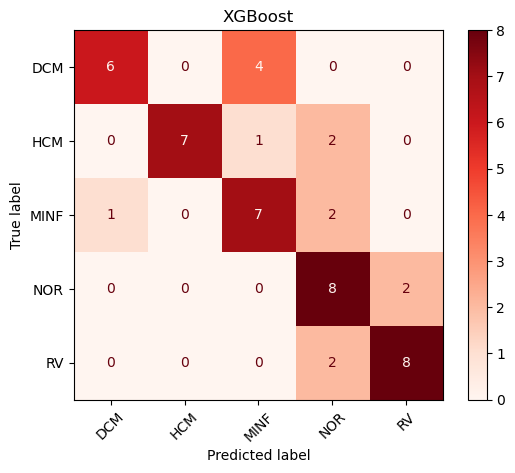

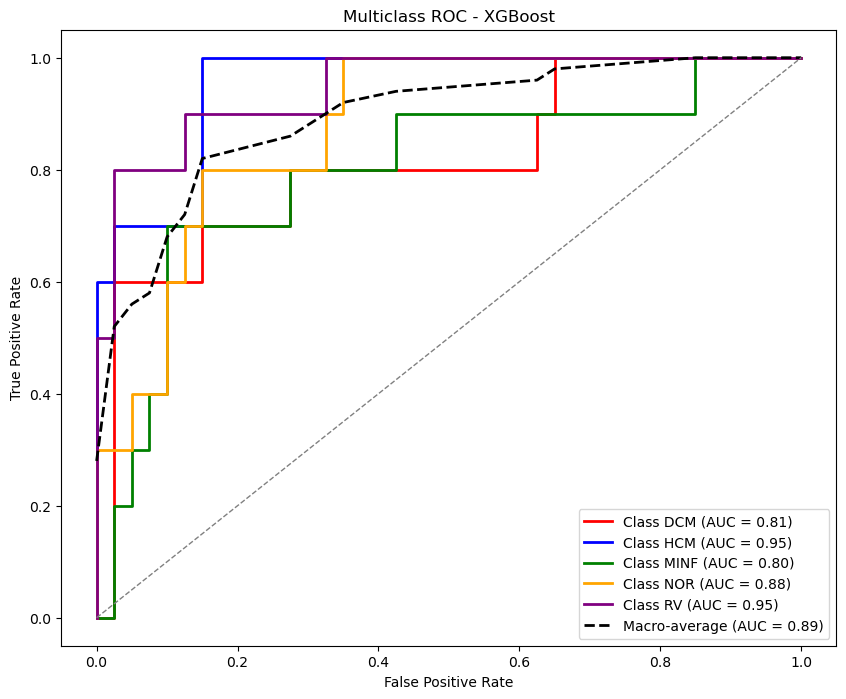

In [40]:
# Optimal ROUSEG XGB
Classification_XGB(ROUSEG_train, ROUSEG_test, y_train, y_test, k=56)

Here we calculate the optimal selection of features for each model in NETSEG

In [41]:
NETSEG_svm, NETSEG_knn, NETSEG_rf, NETSEG_gb, NETSEG_xgb = Accuracy_5Models(NETSEG_train,NETSEG_test,y_train,y_test,features_list)

1

Best parameters for SVM: {'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}

Classification Report (SVM):
              precision    recall  f1-score   support

         DCM       0.55      0.60      0.57        10
         HCM       0.30      0.60      0.40        10
        MINF       0.50      0.50      0.50        10
         NOR       0.38      0.30      0.33        10
          RV       1.00      0.10      0.18        10

    accuracy                           0.42        50
   macro avg       0.54      0.42      0.40        50
weighted avg       0.54      0.42      0.40        50

Macro ROC-AUC (SVM): 0.82

Best parameters for KNN: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

Classification Report (KNN):
              precision    recall  f1-score   support

         DCM       0.54      0.70      0.61        10
         HCM       0.26      0.60      0.36        10
        MINF       0.57      0.40      0.47        10
         NOR       0.40      0.20      0.27        10

In [42]:
get_best(NETSEG_svm)

Best Accuracy-F1Score: [0.7, 0.6992397660818713]
Number of features: 20



Best parameters for SVM: {'C': 0.1, 'degree': 2, 'gamma': 0.0001, 'kernel': 'linear'}

Classification Report (SVM):
              precision    recall  f1-score   support

         DCM       0.60      0.60      0.60        10
         HCM       0.88      0.70      0.78        10
        MINF       0.56      0.50      0.53        10
         NOR       0.64      0.90      0.75        10
          RV       0.89      0.80      0.84        10

    accuracy                           0.70        50
   macro avg       0.71      0.70      0.70        50
weighted avg       0.71      0.70      0.70        50

Macro ROC-AUC (SVM): 0.89


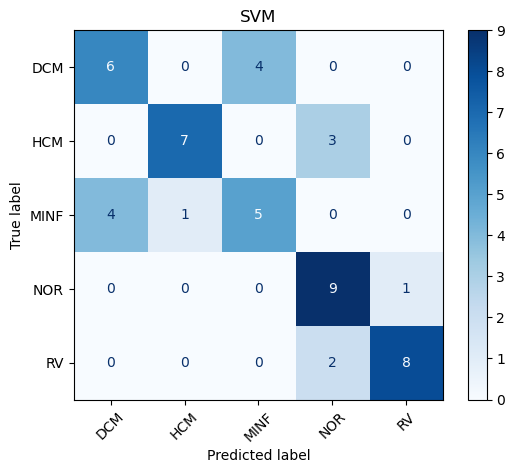

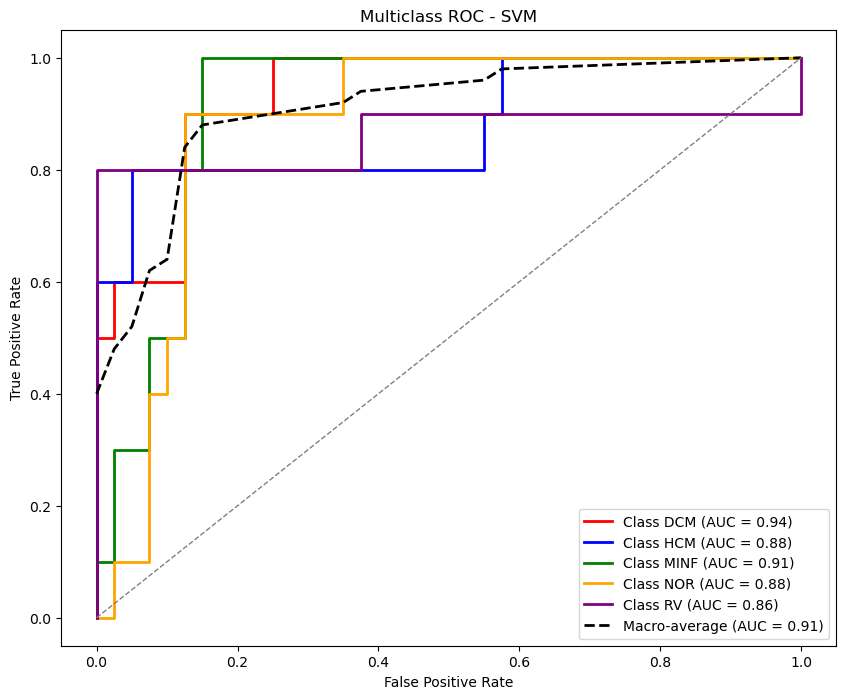

In [43]:
# Optimal NETSEG SVM
Classification_SVM(NETSEG_train, NETSEG_test, y_train, y_test, k=20)

In [44]:
get_best(NETSEG_knn)

Best Accuracy-F1Score: [0.68, 0.6888270944741534]
Number of features: 71



Best parameters for KNN: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}

Classification Report (KNN):
              precision    recall  f1-score   support

         DCM       0.75      0.60      0.67        10
         HCM       1.00      0.70      0.82        10
        MINF       0.67      0.80      0.73        10
         NOR       0.47      0.70      0.56        10
          RV       0.75      0.60      0.67        10

    accuracy                           0.68        50
   macro avg       0.73      0.68      0.69        50
weighted avg       0.73      0.68      0.69        50

Macro ROC-AUC (KNN): 0.90


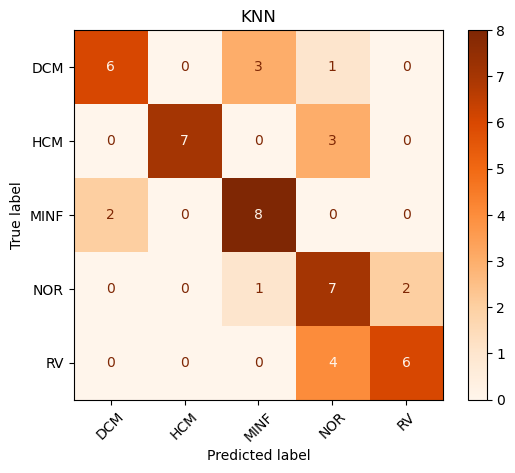

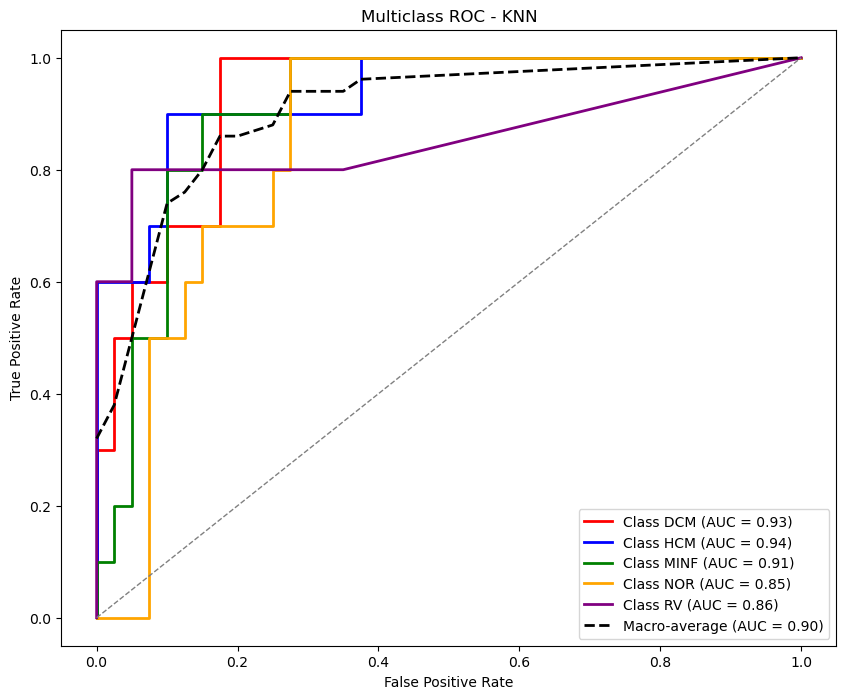

In [46]:
# Optimal NETSEG KNN
Classification_KNN(NETSEG_train, NETSEG_test, y_train, y_test, k=71)

In [48]:
get_best(NETSEG_rf)

Best Accuracy-F1Score: [0.72, 0.7241407867494825]
Number of features: 12



Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}

Classification Report (Random Forest):
              precision    recall  f1-score   support

         DCM       0.60      0.60      0.60        10
         HCM       0.88      0.70      0.78        10
        MINF       0.55      0.60      0.57        10
         NOR       0.69      0.90      0.78        10
          RV       1.00      0.80      0.89        10

    accuracy                           0.72        50
   macro avg       0.74      0.72      0.72        50
weighted avg       0.74      0.72      0.72        50

Macro ROC-AUC (Random Forest): 0.91


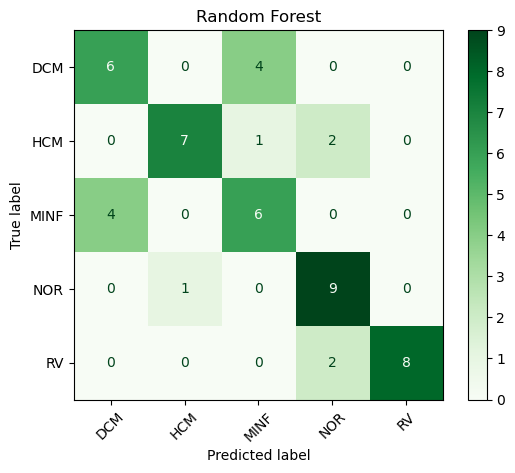

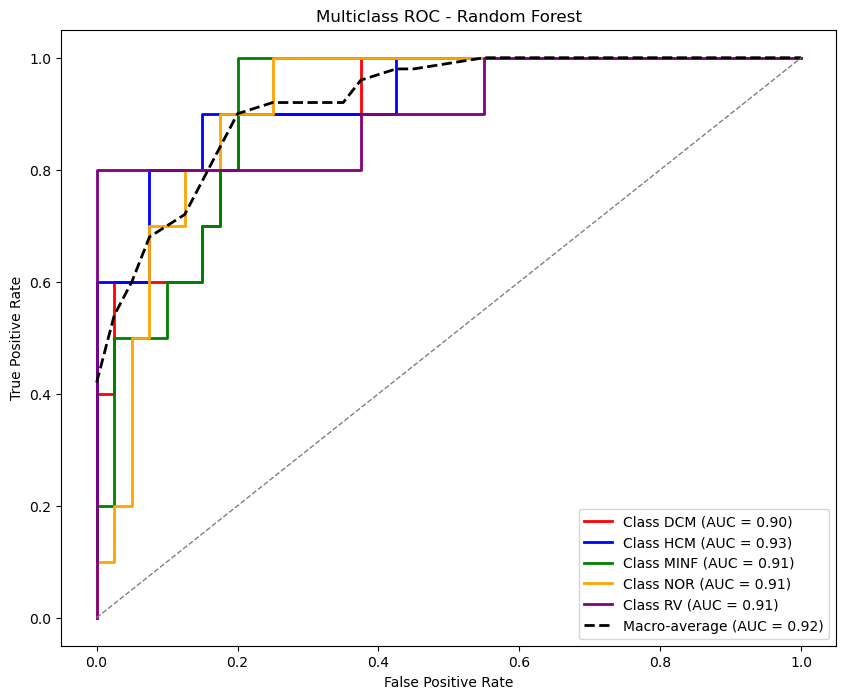

In [50]:
# Optimal NETSEG RF
Classification_RF(NETSEG_train, NETSEG_test, y_train, y_test, k=12)

In [51]:
get_best(NETSEG_gb)

Best Accuracy-F1Score: [0.7, 0.6991387559808612]
Number of features: 22



Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

         DCM       0.60      0.60      0.60        10
         HCM       0.80      0.80      0.80        10
        MINF       0.56      0.50      0.53        10
         NOR       0.67      0.80      0.73        10
          RV       0.89      0.80      0.84        10

    accuracy                           0.70        50
   macro avg       0.70      0.70      0.70        50
weighted avg       0.70      0.70      0.70        50

Macro ROC-AUC (Gradient Boosting): 0.87


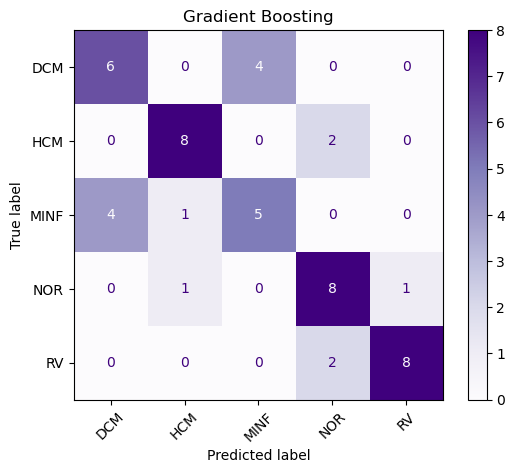

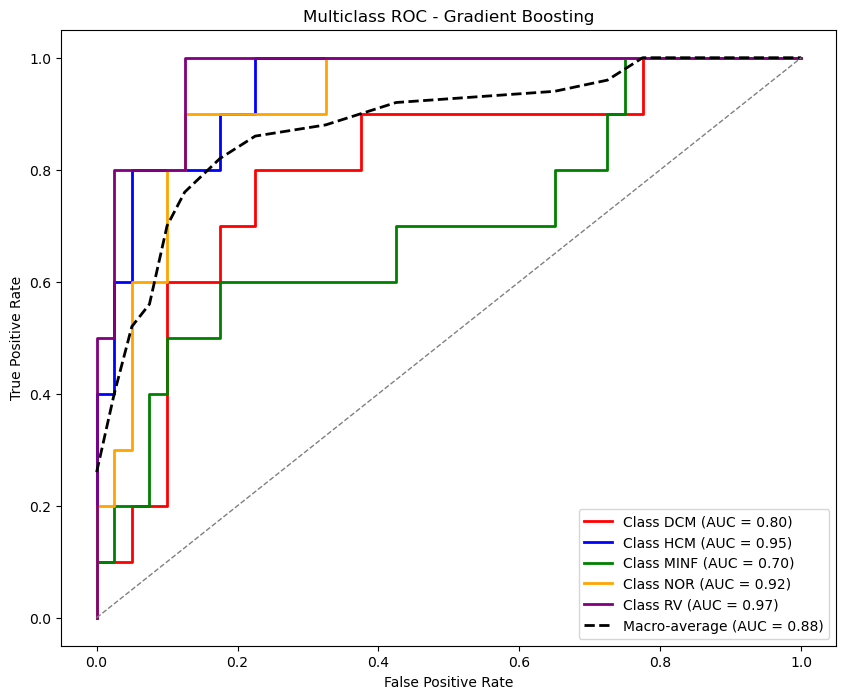

In [52]:
# Optimal NETSEG GB
Classification_GB(NETSEG_train, NETSEG_test, y_train, y_test, k=22)

In [53]:
get_best(NETSEG_xgb)

Best Accuracy-F1Score: [0.68, 0.6830409356725146]
Number of features: 12



Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}

Classification Report (XGBoost):
              precision    recall  f1-score   support

         DCM       0.56      0.50      0.53        10
         HCM       0.73      0.80      0.76        10
        MINF       0.45      0.50      0.48        10
         NOR       0.73      0.80      0.76        10
          RV       1.00      0.80      0.89        10

    accuracy                           0.68        50
   macro avg       0.69      0.68      0.68        50
weighted avg       0.69      0.68      0.68        50

Macro ROC-AUC (XGBoost): 0.89


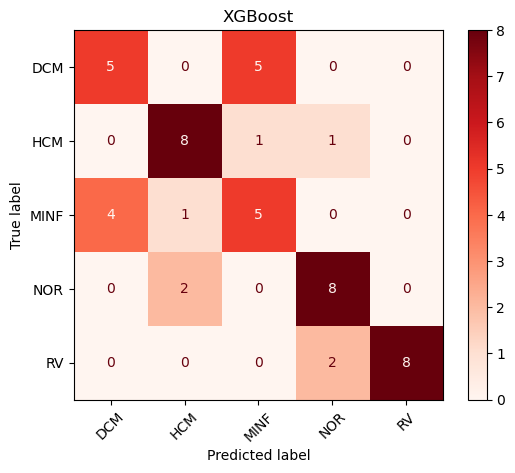

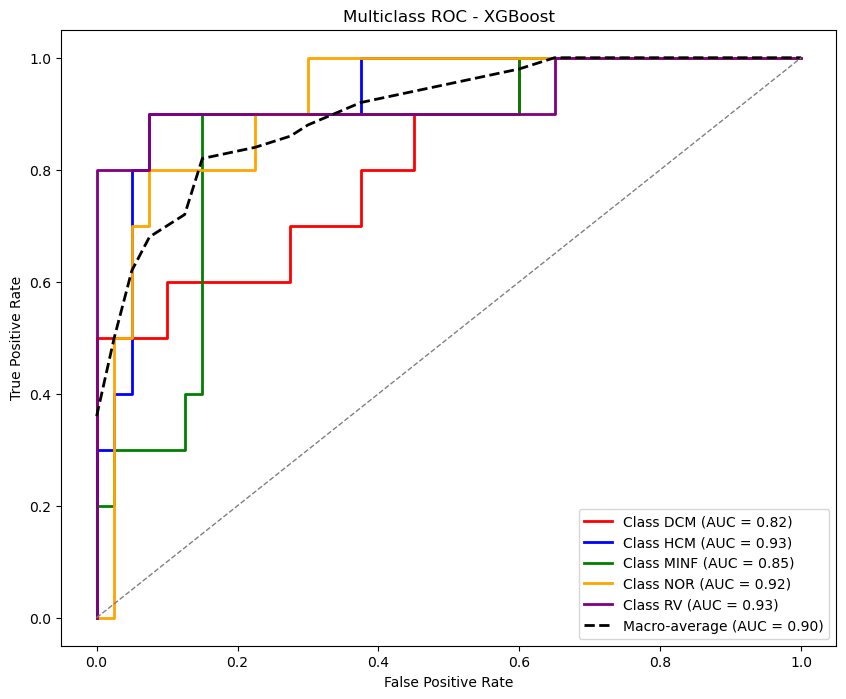

In [54]:
# Optimal NETSEG XGB
Classification_XGB(NETSEG_train, NETSEG_test, y_train, y_test, k=12)